<a href="https://colab.research.google.com/github/rajy4683/S6EVA4/blob/master/S6_AllRuns.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [28]:
from google.colab import drive
drive.mount('/content/drive')
import sys
sys.path.append('/content/drive/My Drive/EVA4/')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
#from MNISTRekog.basemodelclass import MNISTDigitBuilder

In [0]:
#from MNISTRekog.utils.fileutils import *

In [0]:
#print(rand_run_name())
#print(generate_model_save_path())

3196883b4f
/content/drive/My Drive/EVA4/model_saves/model-916ee8cf62.h5


In [29]:
!pip install pytorch-ignite
!pip install torchsummary
!pip install wandb

In [30]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
!pip install torchsummary
from torchsummary import summary
import pandas as pd
import numpy as np

In [0]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torchsummary import summary

from ignite.engine import Events, create_supervised_trainer, create_supervised_evaluator
from ignite.metrics import Accuracy, Loss
from torch.utils.data import DataLoader
from ignite.handlers import Checkpoint, DiskSaver


import logging
logging.propagate = False 
logging.getLogger().setLevel(logging.ERROR)

from argparse import ArgumentParser
from tqdm import tqdm
import os
import random


In [0]:
import logging
logging.propagate = False 

logging.getLogger().setLevel(logging.ERROR)

In [33]:
import wandb
#wandb.init()
#!wandb login a6f947d2d2f69e7a8c8ca0f69811fd554f27d204
#wandb login a6f947d2d2f69e7a8c8ca0f69811fd554f27d204
!wandb login a6f947d2d2f69e7a8c8ca0f69811fd554f27d204

wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
Successfully logged in to Weights & Biases!


In [0]:
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")

In [0]:
############# MNISTRekog.basemodelclass.py ######################
class MNISTDigitBuilder(nn.Module):
    def __init__(self, dropout=0.1):
        super(MNISTDigitBuilder, self).__init__()
        self.dropout_val = dropout
        self.bias = False
        self.conv1 = nn.Sequential(
            nn.Conv2d(1, 8, 3, padding=1, stride=1,bias=self.bias),            
            nn.BatchNorm2d(8),
            nn.ReLU(),
            nn.Dropout(self.dropout_val),
            nn.Conv2d(8, 8, 3, padding=1, stride=1,bias=self.bias),            
            nn.BatchNorm2d(8),
            nn.ReLU(),
            # nn.Conv2d(8, 8, 3, padding=1, bias=self.bias),            
            # nn.BatchNorm2d(8),
            # nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Dropout(self.dropout_val),
        )
        
        self.conv2 = nn.Sequential(
            nn.Conv2d(8, 8, 3, padding=1,stride=1, bias=self.bias),            
            nn.BatchNorm2d(8),
            nn.ReLU(),
            nn.Dropout(self.dropout_val),
            nn.Conv2d(8, 16, 3, padding=1, bias=self.bias),            
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Dropout(self.dropout_val),
            # nn.Conv2d(16, 16, 3, padding=1, bias=self.bias),            
            # nn.BatchNorm2d(16),
            # nn.ReLU(),
            #nn.MaxPool2d(2, 2),
            #nn.Dropout(self.dropout_val)
        )
        
        self.conv3 = nn.Sequential(
            nn.Conv2d(16, 16, 3,bias=self.bias),            
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.Dropout(self.dropout_val),
            nn.Conv2d(16, 16, 3,bias=self.bias),            
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Dropout(self.dropout_val)
        )
        
        self.gap_linear = nn.Sequential(
            nn.AdaptiveAvgPool2d((1,1)),
            nn.Conv2d(16, 10, 1, bias=self.bias)
        )
                
        
    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        
        #x = x.view(x.size(0), -1)
        x = self.gap_linear(x)
        x = x.view(-1, 10)
        x = F.log_softmax(x, dim=1)
        return x

"""
    Creates the model object on the specified device
"""
def model_builder(model_class=None, weights_path=None, local_device=torch.device("cpu")):
    if (model_class == None):
        print("Please provide the model object to be used")
        return
    local_model = model_class()#.to(local_device)
    try:
        if (weights_path != None):
            checkpoint = torch.load(weights_path)
            local_model.load_state_dict(checkpoint['model_state_dict'])
                #torch.load(weights_path, map_location=local_device))           
    except:
        print("Some execption occured during loading the model")
    return local_model.to(local_device)


In [0]:
########### MNISTRekog.fileutils.py
"""
    This file contains non-core utility functions 
    used in the overall project
"""

import random
import os
import numpy as np
import pandas as pd


def rand_run_name():
    ran = random.randrange(10**80)
    myhex = "%064x" % ran
    #limit string to 64 characters
    myhex = myhex[:10]
    return myhex

def generate_model_save_path(base="/content/drive/My Drive/EVA4/model_saves",rand_string=None):
    if rand_string == None:
        rand_string=rand_run_name()
    file_name = "model-"+rand_string+".h5"
    return os.path.join(base,file_name)

"""
    Called per-epoch to log most of the test data
"""
#global_stats_array = np.array([[]])
def stats_logger(stats_array, epoch,
                 train_loss, train_accuracy, 
                 test_loss, test_accuracy, 
                 lr, momentum=0.95, 
                 weight_decay=0):
    return np.append(stats_array, [[epoch,train_loss, train_accuracy, test_loss, test_accuracy, lr, momentum, weight_decay]],axis=0)
    
    #print(global_stats_array)




In [37]:
# WandB – Config is a variable that holds and saves hyperparameters and inputs
# hyperparameter_defaults = dict(
#     dropout = 0.1,
#     channels_one = 16,
#     channels_two = 32,
#     batch_size = 64,
#     test_batch_size=64,
#     lr = 0.018,
#     momentum = 0.9,
#     no_cuda = False,
#     seed = 1,
#     epochs = 20,
#     bias = False,
#     log_interval = 10
#     )

hyperparameter_defaults = dict(
    dropout = 0.1,#0.07114420042272313,
    channels_one = 16,
    channels_two = 32,
    batch_size = 64,
    test_batch_size=34,
    lr = 0.04, #0.030455453938066226, #0.018,# 0.017530428914306426,
    momentum = 0.95, #0.8424379743502641,
    no_cuda = False,
    seed = 1,
    epochs = 15,
    bias = False,
    log_interval = 11,
    sched_lr_gamma = 0.5,
    sched_lr_step= 1,
    start_lr = 5
    )



wandb.init(config=hyperparameter_defaults, project="news4eva4")
wandb.watch_called = False # Re-run the model without restarting the runtime, unnecessary after our next release
config = wandb.config


In [38]:
#from basemodelclass import Net
model = MNISTDigitBuilder(dropout=0.1).to(device)
summary(model, input_size=(1, 28, 28))


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 8, 28, 28]              72
       BatchNorm2d-2            [-1, 8, 28, 28]              16
              ReLU-3            [-1, 8, 28, 28]               0
           Dropout-4            [-1, 8, 28, 28]               0
            Conv2d-5            [-1, 8, 28, 28]             576
       BatchNorm2d-6            [-1, 8, 28, 28]              16
              ReLU-7            [-1, 8, 28, 28]               0
         MaxPool2d-8            [-1, 8, 14, 14]               0
           Dropout-9            [-1, 8, 14, 14]               0
           Conv2d-10            [-1, 8, 14, 14]             576
      BatchNorm2d-11            [-1, 8, 14, 14]              16
             ReLU-12            [-1, 8, 14, 14]               0
          Dropout-13            [-1, 8, 14, 14]               0
           Conv2d-14           [-1, 16,

In [0]:
train_transforms = transforms.Compose([
                                      #  transforms.Resize((28, 28)),
                                      #  transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                       #transforms.RandomRotation((-7.0, 7.0), fill=(1,)),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,)) # The mean and std have to be sequences (e.g., tuples), therefore you should add a comma after the values. 
                                       # Note the difference between (0.1307) and (0.1307,)
                                       ])

# Test Phase transformations
test_transforms = transforms.Compose([
                                      #  transforms.Resize((28, 28)),
                                      #  transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                       #transforms.RandomRotation((-7.0, 7.0), fill=(1,)),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,))
                                       ])

In [0]:
classes = ('0', '1', '2', '3', '4', '5', '6', '7', '8', '9')
train_losses = []
test_losses = []
train_acc = []
test_acc = []

from tqdm import tqdm
def train(args, model, device, train_loader, optimizer, epoch_number,l1_loss=False, l1_beta = 0):
    model.train()
    pbar = tqdm(train_loader)
    train_loss = 0
    train_accuracy = 0
    for batch_idx, (data, target) in enumerate(pbar):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
        train_accuracy += pred.eq(target.view_as(pred)).sum().item()

        loss = F.nll_loss(output, target)
        if l1_loss == True:
            l1_crit = nn.L1Loss(size_average=False)
            reg_loss = 0
            for param in model.parameters():
                target = torch.zeros_like(param)    
                reg_loss += l1_crit(param, target)
            loss += (l1_beta * reg_loss)
        loss.backward()
        optimizer.step()
        pbar.set_description(desc= f'loss={loss.item()} batch_id={batch_idx}')
        train_loss += loss.item()

    train_loss /= len(train_loader.dataset)
    #print('\nEpoch: {:.0f} Train set: Average loss: {:.4f}, Accuracy: {}/{} ({:.3f}%)\n'.format(
    #    epoch_number, train_loss, train_accuracy, len(train_loader.dataset),
    #    100. * train_accuracy / len(train_loader.dataset)))
    train_accuracy = (100. * train_accuracy) / len(train_loader.dataset)
    #train_acc.append(train_accuracy)
    #train_losses.append(train_loss)

    return train_accuracy, train_loss

def test(args, model, device, test_loader,classes,epoch_number):
    model.eval()
    test_loss = 0
    correct = 0
    example_images = []
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()
        #example_images.append(wandb.Image(
        #        data[0], caption="Pred: {} Truth: {}".format(classes[pred[0].item()], classes[target[0]])))

    test_loss /= len(test_loader.dataset)
    test_accuracy = (100. * correct) / len(test_loader.dataset)

    #print('\nEpoch: {:.0f} Test set: Average loss: {:.4f}, Accuracy: {}/{} ({:.3f}%)\n'.format(
    #    epoch_number, test_loss, correct, len(test_loader.dataset),
    #    100. * correct / len(test_loader.dataset)))
    #test_acc.append(test_accuracy)
    #test_losses.append(test_loss)

    return test_accuracy, test_loss

#### Base Model with 40 Epochs
#### Model-Path: /content/drive/My Drive/EVA4/baseline_models/model-3176d58add_baserun40.h5

In [0]:
#model = MNISTDigitBuilder(start_channels=16,exponetate_layers=False).to(device)
#wandb.init(project="news4eva4")
from torch.optim.lr_scheduler import StepLR, OneCycleLR, MultiStepLR
import os
hyperparameter_defaults = dict(
    run_name = rand_run_name(),
    dropout = 0.1,#0.07114420042272313,
    batch_size = 82,
    test_batch_size=34,
    lr = 0.025, #0.00625, #0.042259475404268484, #0.032877745711371975, #0.007, #0.030455453938066226, #0.018,# 0.017530428914306426,
    momentum = 0.9, #0.6635974310124919, #0.824176605049245, #0.95, #0.8424379743502641,
    no_cuda = False,
    seed = 1,
    epochs = 40,
    bias = False,
    sched_lr_gamma = 0.5, #0.7836943786449023, #0.271611419527123, #0.99,
    sched_lr_step= 2,
    start_lr = 7,
    weight_decay=0 #5.740256897290758e-05, #1.8540436495464775e-06
    )

classes = ('0', '1', '2', '3', '4', '5', '6', '7', '8', '9')
# train_losses = []
# test_losses = []
# train_acc = []
# test_acc = []

wandb.init(config=hyperparameter_defaults, project="news4eva4")
wandb.watch_called = False # Re-run the model without restarting the runtime, unnecessary after our next release
config = wandb.config
model_path = generate_model_save_path(rand_string=config.run_name)
print("Model will be saved to:", model_path)
prev_saved_model = "/content/drive/My Drive/EVA4/model_saves/model-14ba52d1d9.h5"
#"/content/drive/My Drive/EVA4/baseline_models/model-1b795c6652.h5"

def main():
    use_cuda = not config.no_cuda and torch.cuda.is_available()
    device = torch.device("cuda" if use_cuda else "cpu")
    kwargs = {'num_workers': 4, 'pin_memory': True} if use_cuda else {}
    
    # Set random seeds and deterministic pytorch for reproducibility
    # random.seed(config.seed)       # python random seed
    torch.manual_seed(config.seed) # pytorch random seed
    # numpy.random.seed(config.seed) # numpy random seed
    torch.backends.cudnn.deterministic = True

    # Load the dataset: We're training our CNN on CIFAR10 (https://www.cs.toronto.edu/~kriz/cifar.html)
    # First we define the tranformations to apply to our images
    #kwargs = {'num_workers': 4, 'pin_memory': True} if use_cuda else {}
    train_loader = torch.utils.data.DataLoader(
        datasets.MNIST('../data', train=True, download=True,
                        transform=train_transforms),
        batch_size=config.batch_size, shuffle=True, **kwargs)
    test_loader = torch.utils.data.DataLoader(
        datasets.MNIST('../data', train=False, transform=test_transforms),
        batch_size=config.batch_size, shuffle=True, **kwargs)

    # Initialize our model, recursively go over all modules and convert their parameters and buffers to CUDA tensors (if device is set to cuda)
    # model = model_builder(MNISTDigitBuilder, 
    #                   weights_path=prev_saved_model,
    #                   local_device=device)
    
    model = MNISTDigitBuilder(dropout=config.dropout).to(device)
    #model.load_state_dict(torch.load(prev_saved_model, map_location=device))

    optimizer = optim.SGD(model.parameters(), lr=config.lr,
                          momentum=config.momentum, weight_decay=config.weight_decay)
    
    scheduler = StepLR(optimizer, step_size=config.sched_lr_step, gamma=config.sched_lr_gamma)
    #scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=config.lr, steps_per_epoch=len(train_loader), epochs=config.epochs)
    #scheduler = MultiStepLR(optimizer, milestones=[10,20], gamma=config.sched_lr_gamma)
    # WandB – wandb.watch() automatically fetches all layer dimensions, gradients, model parameters and logs them automatically to your dashboard.
    # Using log="all" log histograms of parameter values in addition to gradients
    wandb.watch(model, log="all")

    for epoch in range(1, config.epochs + 1):
        epoch_train_acc,epoch_train_loss = train(config, model, device, train_loader, optimizer, epoch)        
        epoch_test_acc,epoch_test_loss = test(config, model, device, test_loader, classes,epoch)

        #epoch_stats
        
        print('\nEpoch: {:.0f} Train set: Average loss: {:.4f}, Accuracy: {:.3f}%'.format(
        epoch, epoch_train_loss, epoch_train_acc))
        print('Epoch: {:.0f} Test set: Average loss: {:.4f}, Accuracy: {:.3f}%'.format(
        epoch, epoch_test_loss, epoch_test_acc))
        myoptim = optimizer.state_dict()['param_groups'][0]
        #print('Epoch: {:.0f} Optimizer values: LR: {:.10f}, LastLR:{:.10f}, Momentum: {:.10f}, Weight Decay: {:.10f}'.format(
        #epoch, scheduler.get_lr()[0],scheduler.get_last_lr()[0],myoptim['momentum'],myoptim['weight_decay']))

        print('Epoch: {:.0f} Optimizer values: LastLR:{:.10f}, Momentum: {:.10f}, Weight Decay: {:.10f}'.format(
        epoch, scheduler.get_last_lr()[0],myoptim['momentum'],myoptim['weight_decay']))

        #stats_logger(global_stats_array, 1,0.1,99.0,0.1,98.0,0.001,0.78,0.00001)
        
        wandb.log({ "Train Accuracy": epoch_train_acc, 
                   "Train Loss": epoch_train_loss, 
                   "Test Accuracy":epoch_test_acc, 
                   "Test Loss": epoch_test_loss,
                   "Learning Rate": config.lr})
                   #"Learning Rate": scheduler.get_lr()})
        if (epoch > config.start_lr):
            scheduler.step()
        
    # WandB – Save the model checkpoint. This automatically saves a file to the cloud and associates it with the current run.

    torch.save({
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict()
            }, model_path)
    wandb.save('model.h5')

if __name__ == '__main__':
    main()

  0%|          | 0/732 [00:00<?, ?it/s]

Model will be saved to: /content/drive/My Drive/EVA4/model_saves/model-3176d58add.h5


  0%|          | 0/732 [00:00<?, ?it/s]


Epoch: 1 Train set: Average loss: 0.0035, Accuracy: 91.235%
Epoch: 1 Test set: Average loss: 0.0679, Accuracy: 97.980%
Epoch: 1 Optimizer values: LastLR:0.0250000000, Momentum: 0.9000000000, Weight Decay: 0.0000000000


  0%|          | 0/732 [00:00<?, ?it/s]


Epoch: 2 Train set: Average loss: 0.0015, Accuracy: 96.352%
Epoch: 2 Test set: Average loss: 0.0457, Accuracy: 98.710%
Epoch: 2 Optimizer values: LastLR:0.0250000000, Momentum: 0.9000000000, Weight Decay: 0.0000000000


  0%|          | 0/732 [00:00<?, ?it/s]


Epoch: 3 Train set: Average loss: 0.0012, Accuracy: 97.050%
Epoch: 3 Test set: Average loss: 0.0374, Accuracy: 98.820%
Epoch: 3 Optimizer values: LastLR:0.0250000000, Momentum: 0.9000000000, Weight Decay: 0.0000000000


  0%|          | 0/732 [00:00<?, ?it/s]


Epoch: 4 Train set: Average loss: 0.0011, Accuracy: 97.332%
Epoch: 4 Test set: Average loss: 0.0290, Accuracy: 99.100%
Epoch: 4 Optimizer values: LastLR:0.0250000000, Momentum: 0.9000000000, Weight Decay: 0.0000000000


  0%|          | 0/732 [00:00<?, ?it/s]


Epoch: 5 Train set: Average loss: 0.0010, Accuracy: 97.592%
Epoch: 5 Test set: Average loss: 0.0367, Accuracy: 98.890%
Epoch: 5 Optimizer values: LastLR:0.0250000000, Momentum: 0.9000000000, Weight Decay: 0.0000000000


  0%|          | 0/732 [00:00<?, ?it/s]


Epoch: 6 Train set: Average loss: 0.0009, Accuracy: 97.688%
Epoch: 6 Test set: Average loss: 0.0285, Accuracy: 99.160%
Epoch: 6 Optimizer values: LastLR:0.0250000000, Momentum: 0.9000000000, Weight Decay: 0.0000000000


  0%|          | 0/732 [00:00<?, ?it/s]


Epoch: 7 Train set: Average loss: 0.0009, Accuracy: 97.807%
Epoch: 7 Test set: Average loss: 0.0260, Accuracy: 99.180%
Epoch: 7 Optimizer values: LastLR:0.0250000000, Momentum: 0.9000000000, Weight Decay: 0.0000000000


  0%|          | 0/732 [00:00<?, ?it/s]


Epoch: 8 Train set: Average loss: 0.0009, Accuracy: 97.842%
Epoch: 8 Test set: Average loss: 0.0272, Accuracy: 99.240%
Epoch: 8 Optimizer values: LastLR:0.0250000000, Momentum: 0.9000000000, Weight Decay: 0.0000000000


  0%|          | 0/732 [00:00<?, ?it/s]


Epoch: 9 Train set: Average loss: 0.0008, Accuracy: 97.960%
Epoch: 9 Test set: Average loss: 0.0274, Accuracy: 99.250%
Epoch: 9 Optimizer values: LastLR:0.0250000000, Momentum: 0.9000000000, Weight Decay: 0.0000000000


  0%|          | 0/732 [00:00<?, ?it/s]


Epoch: 10 Train set: Average loss: 0.0008, Accuracy: 98.192%
Epoch: 10 Test set: Average loss: 0.0240, Accuracy: 99.300%
Epoch: 10 Optimizer values: LastLR:0.0125000000, Momentum: 0.9000000000, Weight Decay: 0.0000000000


  0%|          | 0/732 [00:00<?, ?it/s]


Epoch: 11 Train set: Average loss: 0.0007, Accuracy: 98.287%
Epoch: 11 Test set: Average loss: 0.0236, Accuracy: 99.280%
Epoch: 11 Optimizer values: LastLR:0.0125000000, Momentum: 0.9000000000, Weight Decay: 0.0000000000


  0%|          | 0/732 [00:00<?, ?it/s]


Epoch: 12 Train set: Average loss: 0.0007, Accuracy: 98.330%
Epoch: 12 Test set: Average loss: 0.0232, Accuracy: 99.360%
Epoch: 12 Optimizer values: LastLR:0.0062500000, Momentum: 0.9000000000, Weight Decay: 0.0000000000


  0%|          | 0/732 [00:00<?, ?it/s]


Epoch: 13 Train set: Average loss: 0.0007, Accuracy: 98.325%
Epoch: 13 Test set: Average loss: 0.0218, Accuracy: 99.370%
Epoch: 13 Optimizer values: LastLR:0.0062500000, Momentum: 0.9000000000, Weight Decay: 0.0000000000


  0%|          | 0/732 [00:00<?, ?it/s]


Epoch: 14 Train set: Average loss: 0.0006, Accuracy: 98.412%
Epoch: 14 Test set: Average loss: 0.0221, Accuracy: 99.370%
Epoch: 14 Optimizer values: LastLR:0.0031250000, Momentum: 0.9000000000, Weight Decay: 0.0000000000


  0%|          | 0/732 [00:00<?, ?it/s]


Epoch: 15 Train set: Average loss: 0.0007, Accuracy: 98.392%
Epoch: 15 Test set: Average loss: 0.0229, Accuracy: 99.420%
Epoch: 15 Optimizer values: LastLR:0.0031250000, Momentum: 0.9000000000, Weight Decay: 0.0000000000


  0%|          | 0/732 [00:00<?, ?it/s]


Epoch: 16 Train set: Average loss: 0.0006, Accuracy: 98.517%
Epoch: 16 Test set: Average loss: 0.0230, Accuracy: 99.410%
Epoch: 16 Optimizer values: LastLR:0.0015625000, Momentum: 0.9000000000, Weight Decay: 0.0000000000


  0%|          | 0/732 [00:00<?, ?it/s]


Epoch: 17 Train set: Average loss: 0.0006, Accuracy: 98.513%
Epoch: 17 Test set: Average loss: 0.0222, Accuracy: 99.460%
Epoch: 17 Optimizer values: LastLR:0.0015625000, Momentum: 0.9000000000, Weight Decay: 0.0000000000


  0%|          | 0/732 [00:00<?, ?it/s]


Epoch: 18 Train set: Average loss: 0.0006, Accuracy: 98.550%
Epoch: 18 Test set: Average loss: 0.0221, Accuracy: 99.480%
Epoch: 18 Optimizer values: LastLR:0.0007812500, Momentum: 0.9000000000, Weight Decay: 0.0000000000


  0%|          | 0/732 [00:00<?, ?it/s]


Epoch: 19 Train set: Average loss: 0.0006, Accuracy: 98.527%
Epoch: 19 Test set: Average loss: 0.0227, Accuracy: 99.420%
Epoch: 19 Optimizer values: LastLR:0.0007812500, Momentum: 0.9000000000, Weight Decay: 0.0000000000


  0%|          | 0/732 [00:00<?, ?it/s]


Epoch: 20 Train set: Average loss: 0.0006, Accuracy: 98.513%
Epoch: 20 Test set: Average loss: 0.0233, Accuracy: 99.360%
Epoch: 20 Optimizer values: LastLR:0.0003906250, Momentum: 0.9000000000, Weight Decay: 0.0000000000


  0%|          | 0/732 [00:00<?, ?it/s]


Epoch: 21 Train set: Average loss: 0.0006, Accuracy: 98.490%
Epoch: 21 Test set: Average loss: 0.0223, Accuracy: 99.420%
Epoch: 21 Optimizer values: LastLR:0.0003906250, Momentum: 0.9000000000, Weight Decay: 0.0000000000


  0%|          | 0/732 [00:00<?, ?it/s]


Epoch: 22 Train set: Average loss: 0.0006, Accuracy: 98.500%
Epoch: 22 Test set: Average loss: 0.0225, Accuracy: 99.440%
Epoch: 22 Optimizer values: LastLR:0.0001953125, Momentum: 0.9000000000, Weight Decay: 0.0000000000


  0%|          | 0/732 [00:00<?, ?it/s]


Epoch: 23 Train set: Average loss: 0.0006, Accuracy: 98.540%
Epoch: 23 Test set: Average loss: 0.0220, Accuracy: 99.390%
Epoch: 23 Optimizer values: LastLR:0.0001953125, Momentum: 0.9000000000, Weight Decay: 0.0000000000


  0%|          | 0/732 [00:00<?, ?it/s]


Epoch: 24 Train set: Average loss: 0.0006, Accuracy: 98.578%
Epoch: 24 Test set: Average loss: 0.0222, Accuracy: 99.430%
Epoch: 24 Optimizer values: LastLR:0.0000976563, Momentum: 0.9000000000, Weight Decay: 0.0000000000


  0%|          | 0/732 [00:00<?, ?it/s]


Epoch: 25 Train set: Average loss: 0.0006, Accuracy: 98.567%
Epoch: 25 Test set: Average loss: 0.0225, Accuracy: 99.420%
Epoch: 25 Optimizer values: LastLR:0.0000976563, Momentum: 0.9000000000, Weight Decay: 0.0000000000


  0%|          | 0/732 [00:00<?, ?it/s]


Epoch: 26 Train set: Average loss: 0.0006, Accuracy: 98.473%
Epoch: 26 Test set: Average loss: 0.0223, Accuracy: 99.410%
Epoch: 26 Optimizer values: LastLR:0.0000488281, Momentum: 0.9000000000, Weight Decay: 0.0000000000


  0%|          | 0/732 [00:00<?, ?it/s]


Epoch: 27 Train set: Average loss: 0.0006, Accuracy: 98.520%
Epoch: 27 Test set: Average loss: 0.0224, Accuracy: 99.440%
Epoch: 27 Optimizer values: LastLR:0.0000488281, Momentum: 0.9000000000, Weight Decay: 0.0000000000


  0%|          | 0/732 [00:00<?, ?it/s]


Epoch: 28 Train set: Average loss: 0.0006, Accuracy: 98.510%
Epoch: 28 Test set: Average loss: 0.0226, Accuracy: 99.400%
Epoch: 28 Optimizer values: LastLR:0.0000244141, Momentum: 0.9000000000, Weight Decay: 0.0000000000


  0%|          | 0/732 [00:00<?, ?it/s]


Epoch: 29 Train set: Average loss: 0.0006, Accuracy: 98.530%
Epoch: 29 Test set: Average loss: 0.0222, Accuracy: 99.400%
Epoch: 29 Optimizer values: LastLR:0.0000244141, Momentum: 0.9000000000, Weight Decay: 0.0000000000


  0%|          | 0/732 [00:00<?, ?it/s]


Epoch: 30 Train set: Average loss: 0.0006, Accuracy: 98.460%
Epoch: 30 Test set: Average loss: 0.0225, Accuracy: 99.410%
Epoch: 30 Optimizer values: LastLR:0.0000122070, Momentum: 0.9000000000, Weight Decay: 0.0000000000


  0%|          | 0/732 [00:00<?, ?it/s]


Epoch: 31 Train set: Average loss: 0.0006, Accuracy: 98.497%
Epoch: 31 Test set: Average loss: 0.0216, Accuracy: 99.450%
Epoch: 31 Optimizer values: LastLR:0.0000122070, Momentum: 0.9000000000, Weight Decay: 0.0000000000


  0%|          | 0/732 [00:00<?, ?it/s]


Epoch: 32 Train set: Average loss: 0.0006, Accuracy: 98.507%
Epoch: 32 Test set: Average loss: 0.0225, Accuracy: 99.430%
Epoch: 32 Optimizer values: LastLR:0.0000061035, Momentum: 0.9000000000, Weight Decay: 0.0000000000


  0%|          | 0/732 [00:00<?, ?it/s]


Epoch: 33 Train set: Average loss: 0.0006, Accuracy: 98.517%
Epoch: 33 Test set: Average loss: 0.0221, Accuracy: 99.410%
Epoch: 33 Optimizer values: LastLR:0.0000061035, Momentum: 0.9000000000, Weight Decay: 0.0000000000


  0%|          | 0/732 [00:00<?, ?it/s]


Epoch: 34 Train set: Average loss: 0.0006, Accuracy: 98.502%
Epoch: 34 Test set: Average loss: 0.0223, Accuracy: 99.450%
Epoch: 34 Optimizer values: LastLR:0.0000030518, Momentum: 0.9000000000, Weight Decay: 0.0000000000


  0%|          | 0/732 [00:00<?, ?it/s]


Epoch: 35 Train set: Average loss: 0.0006, Accuracy: 98.565%
Epoch: 35 Test set: Average loss: 0.0221, Accuracy: 99.410%
Epoch: 35 Optimizer values: LastLR:0.0000030518, Momentum: 0.9000000000, Weight Decay: 0.0000000000


  0%|          | 0/732 [00:00<?, ?it/s]


Epoch: 36 Train set: Average loss: 0.0006, Accuracy: 98.592%
Epoch: 36 Test set: Average loss: 0.0221, Accuracy: 99.440%
Epoch: 36 Optimizer values: LastLR:0.0000015259, Momentum: 0.9000000000, Weight Decay: 0.0000000000


  0%|          | 0/732 [00:00<?, ?it/s]


Epoch: 37 Train set: Average loss: 0.0006, Accuracy: 98.478%
Epoch: 37 Test set: Average loss: 0.0225, Accuracy: 99.440%
Epoch: 37 Optimizer values: LastLR:0.0000015259, Momentum: 0.9000000000, Weight Decay: 0.0000000000


  0%|          | 0/732 [00:00<?, ?it/s]


Epoch: 38 Train set: Average loss: 0.0006, Accuracy: 98.605%
Epoch: 38 Test set: Average loss: 0.0229, Accuracy: 99.410%
Epoch: 38 Optimizer values: LastLR:0.0000007629, Momentum: 0.9000000000, Weight Decay: 0.0000000000


  0%|          | 0/732 [00:00<?, ?it/s]


Epoch: 39 Train set: Average loss: 0.0006, Accuracy: 98.510%
Epoch: 39 Test set: Average loss: 0.0229, Accuracy: 99.420%
Epoch: 39 Optimizer values: LastLR:0.0000007629, Momentum: 0.9000000000, Weight Decay: 0.0000000000


loss=0.032581403851509094 batch_id=731: 100%|██████████| 732/732 [00:13<00:00, 54.42it/s]



Epoch: 40 Train set: Average loss: 0.0006, Accuracy: 98.513%
Epoch: 40 Test set: Average loss: 0.0228, Accuracy: 99.400%
Epoch: 40 Optimizer values: LastLR:0.0000003815, Momentum: 0.9000000000, Weight Decay: 0.0000000000


##### L2 + Base Model with 40 Epochs
#### Model-Path: /content/drive/My Drive/EVA4/baseline_models/model-3176d58add_baserun40.h5

In [0]:
#model = MNISTDigitBuilder(start_channels=16,exponetate_layers=False).to(device)
#wandb.init(project="news4eva4")
from torch.optim.lr_scheduler import StepLR, OneCycleLR, MultiStepLR
import os
hyperparameter_defaults = dict(
    run_name = rand_run_name(),
    dropout = 0.1,#0.07114420042272313,
    batch_size = 82,
    test_batch_size=34,
    lr = 0.025, #0.00625, #0.042259475404268484, #0.032877745711371975, #0.007, #0.030455453938066226, #0.018,# 0.017530428914306426,
    momentum = 0.9, #0.6635974310124919, #0.824176605049245, #0.95, #0.8424379743502641,
    no_cuda = False,
    seed = 1,
    epochs = 40,
    bias = False,
    sched_lr_gamma = 0.5, #0.7836943786449023, #0.271611419527123, #0.99,
    sched_lr_step= 2,
    start_lr = 7,
    weight_decay=0.0006905824115205087 #5.740256897290758e-05, #1.8540436495464775e-06
    )

classes = ('0', '1', '2', '3', '4', '5', '6', '7', '8', '9')
# train_losses = []
# test_losses = []
# train_acc = []
# test_acc = []

wandb.init(config=hyperparameter_defaults, project="news4eva4")
wandb.watch_called = False # Re-run the model without restarting the runtime, unnecessary after our next release
config = wandb.config
model_path = generate_model_save_path(rand_string=config.run_name)
print("Model will be saved to:", model_path)
prev_saved_model = "/content/drive/My Drive/EVA4/model_saves/model-14ba52d1d9.h5"
#"/content/drive/My Drive/EVA4/baseline_models/model-1b795c6652.h5"

def main():
    use_cuda = not config.no_cuda and torch.cuda.is_available()
    device = torch.device("cuda" if use_cuda else "cpu")
    kwargs = {'num_workers': 4, 'pin_memory': True} if use_cuda else {}
    
    # Set random seeds and deterministic pytorch for reproducibility
    # random.seed(config.seed)       # python random seed
    torch.manual_seed(config.seed) # pytorch random seed
    # numpy.random.seed(config.seed) # numpy random seed
    torch.backends.cudnn.deterministic = True

    # Load the dataset: We're training our CNN on CIFAR10 (https://www.cs.toronto.edu/~kriz/cifar.html)
    # First we define the tranformations to apply to our images
    #kwargs = {'num_workers': 4, 'pin_memory': True} if use_cuda else {}
    train_loader = torch.utils.data.DataLoader(
        datasets.MNIST('../data', train=True, download=True,
                        transform=train_transforms),
        batch_size=config.batch_size, shuffle=True, **kwargs)
    test_loader = torch.utils.data.DataLoader(
        datasets.MNIST('../data', train=False, transform=test_transforms),
        batch_size=config.batch_size, shuffle=True, **kwargs)

    # Initialize our model, recursively go over all modules and convert their parameters and buffers to CUDA tensors (if device is set to cuda)
    # model = model_builder(MNISTDigitBuilder, 
    #                   weights_path=prev_saved_model,
    #                   local_device=device)
    
    model = MNISTDigitBuilder(dropout=config.dropout).to(device)
    #model.load_state_dict(torch.load(prev_saved_model, map_location=device))

    optimizer = optim.SGD(model.parameters(), lr=config.lr,
                          momentum=config.momentum, weight_decay=config.weight_decay)
    
    scheduler = StepLR(optimizer, step_size=config.sched_lr_step, gamma=config.sched_lr_gamma)
    #scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=config.lr, steps_per_epoch=len(train_loader), epochs=config.epochs)
    #scheduler = MultiStepLR(optimizer, milestones=[10,20], gamma=config.sched_lr_gamma)
    # WandB – wandb.watch() automatically fetches all layer dimensions, gradients, model parameters and logs them automatically to your dashboard.
    # Using log="all" log histograms of parameter values in addition to gradients
    wandb.watch(model, log="all")

    for epoch in range(1, config.epochs + 1):
        epoch_train_acc,epoch_train_loss = train(config, model, device, train_loader, optimizer, epoch)        
        epoch_test_acc,epoch_test_loss = test(config, model, device, test_loader, classes,epoch)

        #epoch_stats
        
        print('\nEpoch: {:.0f} Train set: Average loss: {:.4f}, Accuracy: {:.3f}%'.format(
        epoch, epoch_train_loss, epoch_train_acc))
        print('Epoch: {:.0f} Test set: Average loss: {:.4f}, Accuracy: {:.3f}%'.format(
        epoch, epoch_test_loss, epoch_test_acc))
        myoptim = optimizer.state_dict()['param_groups'][0]
        #print('Epoch: {:.0f} Optimizer values: LR: {:.10f}, LastLR:{:.10f}, Momentum: {:.10f}, Weight Decay: {:.10f}'.format(
        #epoch, scheduler.get_lr()[0],scheduler.get_last_lr()[0],myoptim['momentum'],myoptim['weight_decay']))

        print('Epoch: {:.0f} Optimizer values: LastLR:{:.10f}, Momentum: {:.10f}, Weight Decay: {:.10f}'.format(
        epoch, scheduler.get_last_lr()[0],myoptim['momentum'],myoptim['weight_decay']))

        #stats_logger(global_stats_array, 1,0.1,99.0,0.1,98.0,0.001,0.78,0.00001)
        
        wandb.log({ "Train Accuracy": epoch_train_acc, 
                   "Train Loss": epoch_train_loss, 
                   "Test Accuracy":epoch_test_acc, 
                   "Test Loss": epoch_test_loss,
                   "Learning Rate": config.lr})
                   #"Learning Rate": scheduler.get_lr()})
        if (epoch > config.start_lr):
            scheduler.step()
        
    # WandB – Save the model checkpoint. This automatically saves a file to the cloud and associates it with the current run.

    torch.save({
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict()
            }, model_path)
    wandb.save('model.h5')

if __name__ == '__main__':
    main()

  0%|          | 0/732 [00:00<?, ?it/s]

Model will be saved to: /content/drive/My Drive/EVA4/model_saves/model-1a74d5814d.h5


  0%|          | 0/732 [00:00<?, ?it/s]


Epoch: 1 Train set: Average loss: 0.0038, Accuracy: 90.168%
Epoch: 1 Test set: Average loss: 0.0839, Accuracy: 97.470%
Epoch: 1 Optimizer values: LastLR:0.0250000000, Momentum: 0.9000000000, Weight Decay: 0.0006905824


  0%|          | 0/732 [00:00<?, ?it/s]


Epoch: 2 Train set: Average loss: 0.0016, Accuracy: 96.235%
Epoch: 2 Test set: Average loss: 0.0446, Accuracy: 98.670%
Epoch: 2 Optimizer values: LastLR:0.0250000000, Momentum: 0.9000000000, Weight Decay: 0.0006905824


  0%|          | 0/732 [00:00<?, ?it/s]


Epoch: 3 Train set: Average loss: 0.0013, Accuracy: 96.855%
Epoch: 3 Test set: Average loss: 0.0416, Accuracy: 98.870%
Epoch: 3 Optimizer values: LastLR:0.0250000000, Momentum: 0.9000000000, Weight Decay: 0.0006905824


  0%|          | 0/732 [00:00<?, ?it/s]


Epoch: 4 Train set: Average loss: 0.0011, Accuracy: 97.245%
Epoch: 4 Test set: Average loss: 0.0374, Accuracy: 98.890%
Epoch: 4 Optimizer values: LastLR:0.0250000000, Momentum: 0.9000000000, Weight Decay: 0.0006905824


  0%|          | 0/732 [00:00<?, ?it/s]


Epoch: 5 Train set: Average loss: 0.0011, Accuracy: 97.390%
Epoch: 5 Test set: Average loss: 0.0352, Accuracy: 99.030%
Epoch: 5 Optimizer values: LastLR:0.0250000000, Momentum: 0.9000000000, Weight Decay: 0.0006905824


  0%|          | 0/732 [00:00<?, ?it/s]


Epoch: 6 Train set: Average loss: 0.0011, Accuracy: 97.440%
Epoch: 6 Test set: Average loss: 0.0335, Accuracy: 98.970%
Epoch: 6 Optimizer values: LastLR:0.0250000000, Momentum: 0.9000000000, Weight Decay: 0.0006905824


  0%|          | 0/732 [00:00<?, ?it/s]


Epoch: 7 Train set: Average loss: 0.0010, Accuracy: 97.525%
Epoch: 7 Test set: Average loss: 0.0375, Accuracy: 98.960%
Epoch: 7 Optimizer values: LastLR:0.0250000000, Momentum: 0.9000000000, Weight Decay: 0.0006905824


  0%|          | 0/732 [00:00<?, ?it/s]


Epoch: 8 Train set: Average loss: 0.0010, Accuracy: 97.595%
Epoch: 8 Test set: Average loss: 0.0485, Accuracy: 98.670%
Epoch: 8 Optimizer values: LastLR:0.0250000000, Momentum: 0.9000000000, Weight Decay: 0.0006905824


  0%|          | 0/732 [00:00<?, ?it/s]


Epoch: 9 Train set: Average loss: 0.0010, Accuracy: 97.567%
Epoch: 9 Test set: Average loss: 0.0365, Accuracy: 98.900%
Epoch: 9 Optimizer values: LastLR:0.0250000000, Momentum: 0.9000000000, Weight Decay: 0.0006905824


  0%|          | 0/732 [00:00<?, ?it/s]


Epoch: 10 Train set: Average loss: 0.0008, Accuracy: 98.040%
Epoch: 10 Test set: Average loss: 0.0263, Accuracy: 99.250%
Epoch: 10 Optimizer values: LastLR:0.0125000000, Momentum: 0.9000000000, Weight Decay: 0.0006905824


  0%|          | 0/732 [00:00<?, ?it/s]


Epoch: 11 Train set: Average loss: 0.0008, Accuracy: 98.077%
Epoch: 11 Test set: Average loss: 0.0280, Accuracy: 99.210%
Epoch: 11 Optimizer values: LastLR:0.0125000000, Momentum: 0.9000000000, Weight Decay: 0.0006905824


  0%|          | 0/732 [00:00<?, ?it/s]


Epoch: 12 Train set: Average loss: 0.0007, Accuracy: 98.325%
Epoch: 12 Test set: Average loss: 0.0267, Accuracy: 99.260%
Epoch: 12 Optimizer values: LastLR:0.0062500000, Momentum: 0.9000000000, Weight Decay: 0.0006905824


  0%|          | 0/732 [00:00<?, ?it/s]


Epoch: 13 Train set: Average loss: 0.0007, Accuracy: 98.298%
Epoch: 13 Test set: Average loss: 0.0250, Accuracy: 99.180%
Epoch: 13 Optimizer values: LastLR:0.0062500000, Momentum: 0.9000000000, Weight Decay: 0.0006905824


  0%|          | 0/732 [00:00<?, ?it/s]


Epoch: 14 Train set: Average loss: 0.0007, Accuracy: 98.468%
Epoch: 14 Test set: Average loss: 0.0246, Accuracy: 99.330%
Epoch: 14 Optimizer values: LastLR:0.0031250000, Momentum: 0.9000000000, Weight Decay: 0.0006905824


  0%|          | 0/732 [00:00<?, ?it/s]


Epoch: 15 Train set: Average loss: 0.0007, Accuracy: 98.465%
Epoch: 15 Test set: Average loss: 0.0248, Accuracy: 99.290%
Epoch: 15 Optimizer values: LastLR:0.0031250000, Momentum: 0.9000000000, Weight Decay: 0.0006905824


  0%|          | 0/732 [00:00<?, ?it/s]


Epoch: 16 Train set: Average loss: 0.0006, Accuracy: 98.542%
Epoch: 16 Test set: Average loss: 0.0255, Accuracy: 99.280%
Epoch: 16 Optimizer values: LastLR:0.0015625000, Momentum: 0.9000000000, Weight Decay: 0.0006905824


  0%|          | 0/732 [00:00<?, ?it/s]


Epoch: 17 Train set: Average loss: 0.0006, Accuracy: 98.520%
Epoch: 17 Test set: Average loss: 0.0219, Accuracy: 99.390%
Epoch: 17 Optimizer values: LastLR:0.0015625000, Momentum: 0.9000000000, Weight Decay: 0.0006905824


  0%|          | 0/732 [00:00<?, ?it/s]


Epoch: 18 Train set: Average loss: 0.0006, Accuracy: 98.570%
Epoch: 18 Test set: Average loss: 0.0218, Accuracy: 99.330%
Epoch: 18 Optimizer values: LastLR:0.0007812500, Momentum: 0.9000000000, Weight Decay: 0.0006905824


  0%|          | 0/732 [00:00<?, ?it/s]


Epoch: 19 Train set: Average loss: 0.0006, Accuracy: 98.633%
Epoch: 19 Test set: Average loss: 0.0225, Accuracy: 99.380%
Epoch: 19 Optimizer values: LastLR:0.0007812500, Momentum: 0.9000000000, Weight Decay: 0.0006905824


  0%|          | 0/732 [00:00<?, ?it/s]


Epoch: 20 Train set: Average loss: 0.0006, Accuracy: 98.635%
Epoch: 20 Test set: Average loss: 0.0229, Accuracy: 99.390%
Epoch: 20 Optimizer values: LastLR:0.0003906250, Momentum: 0.9000000000, Weight Decay: 0.0006905824


  0%|          | 0/732 [00:00<?, ?it/s]


Epoch: 21 Train set: Average loss: 0.0006, Accuracy: 98.637%
Epoch: 21 Test set: Average loss: 0.0219, Accuracy: 99.380%
Epoch: 21 Optimizer values: LastLR:0.0003906250, Momentum: 0.9000000000, Weight Decay: 0.0006905824


  0%|          | 0/732 [00:00<?, ?it/s]


Epoch: 22 Train set: Average loss: 0.0006, Accuracy: 98.713%
Epoch: 22 Test set: Average loss: 0.0226, Accuracy: 99.350%
Epoch: 22 Optimizer values: LastLR:0.0001953125, Momentum: 0.9000000000, Weight Decay: 0.0006905824


  0%|          | 0/732 [00:00<?, ?it/s]


Epoch: 23 Train set: Average loss: 0.0006, Accuracy: 98.615%
Epoch: 23 Test set: Average loss: 0.0220, Accuracy: 99.340%
Epoch: 23 Optimizer values: LastLR:0.0001953125, Momentum: 0.9000000000, Weight Decay: 0.0006905824


  0%|          | 0/732 [00:00<?, ?it/s]


Epoch: 24 Train set: Average loss: 0.0006, Accuracy: 98.635%
Epoch: 24 Test set: Average loss: 0.0224, Accuracy: 99.350%
Epoch: 24 Optimizer values: LastLR:0.0000976563, Momentum: 0.9000000000, Weight Decay: 0.0006905824


  0%|          | 0/732 [00:00<?, ?it/s]


Epoch: 25 Train set: Average loss: 0.0006, Accuracy: 98.608%
Epoch: 25 Test set: Average loss: 0.0226, Accuracy: 99.360%
Epoch: 25 Optimizer values: LastLR:0.0000976563, Momentum: 0.9000000000, Weight Decay: 0.0006905824


  0%|          | 0/732 [00:00<?, ?it/s]


Epoch: 26 Train set: Average loss: 0.0006, Accuracy: 98.677%
Epoch: 26 Test set: Average loss: 0.0225, Accuracy: 99.340%
Epoch: 26 Optimizer values: LastLR:0.0000488281, Momentum: 0.9000000000, Weight Decay: 0.0006905824


  0%|          | 0/732 [00:00<?, ?it/s]


Epoch: 27 Train set: Average loss: 0.0006, Accuracy: 98.620%
Epoch: 27 Test set: Average loss: 0.0225, Accuracy: 99.370%
Epoch: 27 Optimizer values: LastLR:0.0000488281, Momentum: 0.9000000000, Weight Decay: 0.0006905824


  0%|          | 0/732 [00:00<?, ?it/s]


Epoch: 28 Train set: Average loss: 0.0006, Accuracy: 98.640%
Epoch: 28 Test set: Average loss: 0.0227, Accuracy: 99.390%
Epoch: 28 Optimizer values: LastLR:0.0000244141, Momentum: 0.9000000000, Weight Decay: 0.0006905824


  0%|          | 0/732 [00:00<?, ?it/s]


Epoch: 29 Train set: Average loss: 0.0006, Accuracy: 98.638%
Epoch: 29 Test set: Average loss: 0.0223, Accuracy: 99.390%
Epoch: 29 Optimizer values: LastLR:0.0000244141, Momentum: 0.9000000000, Weight Decay: 0.0006905824


  0%|          | 0/732 [00:00<?, ?it/s]


Epoch: 30 Train set: Average loss: 0.0006, Accuracy: 98.605%
Epoch: 30 Test set: Average loss: 0.0226, Accuracy: 99.370%
Epoch: 30 Optimizer values: LastLR:0.0000122070, Momentum: 0.9000000000, Weight Decay: 0.0006905824


  0%|          | 0/732 [00:00<?, ?it/s]


Epoch: 31 Train set: Average loss: 0.0006, Accuracy: 98.557%
Epoch: 31 Test set: Average loss: 0.0222, Accuracy: 99.370%
Epoch: 31 Optimizer values: LastLR:0.0000122070, Momentum: 0.9000000000, Weight Decay: 0.0006905824


  0%|          | 0/732 [00:00<?, ?it/s]


Epoch: 32 Train set: Average loss: 0.0006, Accuracy: 98.658%
Epoch: 32 Test set: Average loss: 0.0228, Accuracy: 99.360%
Epoch: 32 Optimizer values: LastLR:0.0000061035, Momentum: 0.9000000000, Weight Decay: 0.0006905824


  0%|          | 0/732 [00:00<?, ?it/s]


Epoch: 33 Train set: Average loss: 0.0006, Accuracy: 98.653%
Epoch: 33 Test set: Average loss: 0.0224, Accuracy: 99.380%
Epoch: 33 Optimizer values: LastLR:0.0000061035, Momentum: 0.9000000000, Weight Decay: 0.0006905824


  0%|          | 0/732 [00:00<?, ?it/s]


Epoch: 34 Train set: Average loss: 0.0006, Accuracy: 98.667%
Epoch: 34 Test set: Average loss: 0.0224, Accuracy: 99.350%
Epoch: 34 Optimizer values: LastLR:0.0000030518, Momentum: 0.9000000000, Weight Decay: 0.0006905824


  0%|          | 0/732 [00:00<?, ?it/s]


Epoch: 35 Train set: Average loss: 0.0006, Accuracy: 98.705%
Epoch: 35 Test set: Average loss: 0.0222, Accuracy: 99.340%
Epoch: 35 Optimizer values: LastLR:0.0000030518, Momentum: 0.9000000000, Weight Decay: 0.0006905824


  0%|          | 0/732 [00:00<?, ?it/s]


Epoch: 36 Train set: Average loss: 0.0006, Accuracy: 98.542%
Epoch: 36 Test set: Average loss: 0.0223, Accuracy: 99.360%
Epoch: 36 Optimizer values: LastLR:0.0000015259, Momentum: 0.9000000000, Weight Decay: 0.0006905824


  0%|          | 0/732 [00:00<?, ?it/s]


Epoch: 37 Train set: Average loss: 0.0006, Accuracy: 98.582%
Epoch: 37 Test set: Average loss: 0.0227, Accuracy: 99.360%
Epoch: 37 Optimizer values: LastLR:0.0000015259, Momentum: 0.9000000000, Weight Decay: 0.0006905824


  0%|          | 0/732 [00:00<?, ?it/s]


Epoch: 38 Train set: Average loss: 0.0006, Accuracy: 98.598%
Epoch: 38 Test set: Average loss: 0.0229, Accuracy: 99.360%
Epoch: 38 Optimizer values: LastLR:0.0000007629, Momentum: 0.9000000000, Weight Decay: 0.0006905824


  0%|          | 0/732 [00:00<?, ?it/s]


Epoch: 39 Train set: Average loss: 0.0006, Accuracy: 98.615%
Epoch: 39 Test set: Average loss: 0.0232, Accuracy: 99.350%
Epoch: 39 Optimizer values: LastLR:0.0000007629, Momentum: 0.9000000000, Weight Decay: 0.0006905824


loss=0.019569693133234978 batch_id=731: 100%|██████████| 732/732 [00:15<00:00, 47.81it/s]



Epoch: 40 Train set: Average loss: 0.0006, Accuracy: 98.642%
Epoch: 40 Test set: Average loss: 0.0229, Accuracy: 99.340%
Epoch: 40 Optimizer values: LastLR:0.0000003815, Momentum: 0.9000000000, Weight Decay: 0.0006905824


#### L1 + Base Model with 40 Epochs
#### Model-Path: /content/drive/My Drive/EVA4/baseline_models/model-3176d58add_baserun40.h5

In [0]:
#model = MNISTDigitBuilder(start_channels=16,exponetate_layers=False).to(device)
#wandb.init(project="news4eva4")
from torch.optim.lr_scheduler import StepLR, OneCycleLR, MultiStepLR
import os
hyperparameter_defaults = dict(
    run_name = rand_run_name(),
    dropout = 0.1,#0.07114420042272313,
    batch_size = 82,
    test_batch_size=34,
    lr = 0.025, #0.00625, #0.042259475404268484, #0.032877745711371975, #0.007, #0.030455453938066226, #0.018,# 0.017530428914306426,
    momentum = 0.9, #0.6635974310124919, #0.824176605049245, #0.95, #0.8424379743502641,
    no_cuda = False,
    seed = 1,
    epochs = 40,
    bias = False,
    sched_lr_gamma = 0.5, #0.7836943786449023, #0.271611419527123, #0.99,
    sched_lr_step= 2,
    start_lr = 7,
    weight_decay=0,  #0.0006905824115205087 #5.740256897290758e-05, #1.8540436495464775e-06
    use_l1_loss = True,
    l1_decay = 0.00005
    )

classes = ('0', '1', '2', '3', '4', '5', '6', '7', '8', '9')
# train_losses = []
# test_losses = []
# train_acc = []
# test_acc = []

wandb.init(config=hyperparameter_defaults, project="news4eva4")
wandb.watch_called = False # Re-run the model without restarting the runtime, unnecessary after our next release
config = wandb.config
model_path = generate_model_save_path(rand_string=config.run_name)
print("Model will be saved to:", model_path)
prev_saved_model = "/content/drive/My Drive/EVA4/model_saves/model-14ba52d1d9.h5"
#"/content/drive/My Drive/EVA4/baseline_models/model-1b795c6652.h5"

def main():
    use_cuda = not config.no_cuda and torch.cuda.is_available()
    device = torch.device("cuda" if use_cuda else "cpu")
    kwargs = {'num_workers': 4, 'pin_memory': True} if use_cuda else {}
    
    # Set random seeds and deterministic pytorch for reproducibility
    # random.seed(config.seed)       # python random seed
    torch.manual_seed(config.seed) # pytorch random seed
    # numpy.random.seed(config.seed) # numpy random seed
    torch.backends.cudnn.deterministic = True

    # Load the dataset: We're training our CNN on CIFAR10 (https://www.cs.toronto.edu/~kriz/cifar.html)
    # First we define the tranformations to apply to our images
    #kwargs = {'num_workers': 4, 'pin_memory': True} if use_cuda else {}
    train_loader = torch.utils.data.DataLoader(
        datasets.MNIST('../data', train=True, download=True,
                        transform=train_transforms),
        batch_size=config.batch_size, shuffle=True, **kwargs)
    test_loader = torch.utils.data.DataLoader(
        datasets.MNIST('../data', train=False, transform=test_transforms),
        batch_size=config.batch_size, shuffle=True, **kwargs)

    # Initialize our model, recursively go over all modules and convert their parameters and buffers to CUDA tensors (if device is set to cuda)
    # model = model_builder(MNISTDigitBuilder, 
    #                   weights_path=prev_saved_model,
    #                   local_device=device)
    
    model = MNISTDigitBuilder(dropout=config.dropout).to(device)
    #model.load_state_dict(torch.load(prev_saved_model, map_location=device))

    optimizer = optim.SGD(model.parameters(), lr=config.lr,
                          momentum=config.momentum, weight_decay=config.weight_decay)
    
    scheduler = StepLR(optimizer, step_size=config.sched_lr_step, gamma=config.sched_lr_gamma)
    #scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=config.lr, steps_per_epoch=len(train_loader), epochs=config.epochs)
    #scheduler = MultiStepLR(optimizer, milestones=[10,20], gamma=config.sched_lr_gamma)
    # WandB – wandb.watch() automatically fetches all layer dimensions, gradients, model parameters and logs them automatically to your dashboard.
    # Using log="all" log histograms of parameter values in addition to gradients
    wandb.watch(model, log="all")

    for epoch in range(1, config.epochs + 1):
        epoch_train_acc,epoch_train_loss = train(config, model, device, train_loader, optimizer, epoch, l1_loss = config.use_l1_loss, l1_beta=config.l1_decay)        
        epoch_test_acc,epoch_test_loss = test(config, model, device, test_loader, classes,epoch)

        #epoch_stats
        
        print('\nEpoch: {:.0f} Train set: Average loss: {:.4f}, Accuracy: {:.3f}%'.format(
        epoch, epoch_train_loss, epoch_train_acc))
        print('Epoch: {:.0f} Test set: Average loss: {:.4f}, Accuracy: {:.3f}%'.format(
        epoch, epoch_test_loss, epoch_test_acc))
        myoptim = optimizer.state_dict()['param_groups'][0]
        #print('Epoch: {:.0f} Optimizer values: LR: {:.10f}, LastLR:{:.10f}, Momentum: {:.10f}, Weight Decay: {:.10f}'.format(
        #epoch, scheduler.get_lr()[0],scheduler.get_last_lr()[0],myoptim['momentum'],myoptim['weight_decay']))

        print('Epoch: {:.0f} Optimizer values: LastLR:{:.10f}, Momentum: {:.10f}, Weight Decay: {:.10f}'.format(
        epoch, scheduler.get_last_lr()[0],myoptim['momentum'],myoptim['weight_decay']))

        #stats_logger(global_stats_array, 1,0.1,99.0,0.1,98.0,0.001,0.78,0.00001)
        
        wandb.log({ "Train Accuracy": epoch_train_acc, 
                   "Train Loss": epoch_train_loss, 
                   "Test Accuracy":epoch_test_acc, 
                   "Test Loss": epoch_test_loss,
                   "Learning Rate": config.lr})
                   #"Learning Rate": scheduler.get_lr()})
        if (epoch > config.start_lr):
            scheduler.step()
        
    # WandB – Save the model checkpoint. This automatically saves a file to the cloud and associates it with the current run.

    torch.save({
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict()
            }, model_path)
    wandb.save('model.h5')

if __name__ == '__main__':
    main()

  0%|          | 0/732 [00:00<?, ?it/s]

Model will be saved to: /content/drive/My Drive/EVA4/model_saves/model-240a4abf69.h5


/usr/local/lib/python3.6/dist-packages/torch/nn/_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
  0%|          | 0/732 [00:00<?, ?it/s]


Epoch: 1 Train set: Average loss: 0.0041, Accuracy: 90.478%
Epoch: 1 Test set: Average loss: 0.0713, Accuracy: 97.930%
Epoch: 1 Optimizer values: LastLR:0.0250000000, Momentum: 0.9000000000, Weight Decay: 0.0000000000


  0%|          | 0/732 [00:00<?, ?it/s]


Epoch: 2 Train set: Average loss: 0.0020, Accuracy: 96.228%
Epoch: 2 Test set: Average loss: 0.0494, Accuracy: 98.580%
Epoch: 2 Optimizer values: LastLR:0.0250000000, Momentum: 0.9000000000, Weight Decay: 0.0000000000


  0%|          | 0/732 [00:00<?, ?it/s]


Epoch: 3 Train set: Average loss: 0.0018, Accuracy: 96.930%
Epoch: 3 Test set: Average loss: 0.0448, Accuracy: 98.580%
Epoch: 3 Optimizer values: LastLR:0.0250000000, Momentum: 0.9000000000, Weight Decay: 0.0000000000


  0%|          | 0/732 [00:00<?, ?it/s]


Epoch: 4 Train set: Average loss: 0.0016, Accuracy: 97.312%
Epoch: 4 Test set: Average loss: 0.0356, Accuracy: 98.920%
Epoch: 4 Optimizer values: LastLR:0.0250000000, Momentum: 0.9000000000, Weight Decay: 0.0000000000


  0%|          | 0/732 [00:00<?, ?it/s]


Epoch: 5 Train set: Average loss: 0.0016, Accuracy: 97.438%
Epoch: 5 Test set: Average loss: 0.0382, Accuracy: 98.990%
Epoch: 5 Optimizer values: LastLR:0.0250000000, Momentum: 0.9000000000, Weight Decay: 0.0000000000


  0%|          | 0/732 [00:00<?, ?it/s]


Epoch: 6 Train set: Average loss: 0.0015, Accuracy: 97.575%
Epoch: 6 Test set: Average loss: 0.0322, Accuracy: 99.030%
Epoch: 6 Optimizer values: LastLR:0.0250000000, Momentum: 0.9000000000, Weight Decay: 0.0000000000


  0%|          | 0/732 [00:00<?, ?it/s]


Epoch: 7 Train set: Average loss: 0.0015, Accuracy: 97.648%
Epoch: 7 Test set: Average loss: 0.0294, Accuracy: 99.180%
Epoch: 7 Optimizer values: LastLR:0.0250000000, Momentum: 0.9000000000, Weight Decay: 0.0000000000


  0%|          | 0/732 [00:00<?, ?it/s]


Epoch: 8 Train set: Average loss: 0.0015, Accuracy: 97.713%
Epoch: 8 Test set: Average loss: 0.0344, Accuracy: 98.970%
Epoch: 8 Optimizer values: LastLR:0.0250000000, Momentum: 0.9000000000, Weight Decay: 0.0000000000


  0%|          | 0/732 [00:00<?, ?it/s]


Epoch: 9 Train set: Average loss: 0.0015, Accuracy: 97.822%
Epoch: 9 Test set: Average loss: 0.0386, Accuracy: 98.960%
Epoch: 9 Optimizer values: LastLR:0.0250000000, Momentum: 0.9000000000, Weight Decay: 0.0000000000


  0%|          | 0/732 [00:00<?, ?it/s]


Epoch: 10 Train set: Average loss: 0.0013, Accuracy: 98.122%
Epoch: 10 Test set: Average loss: 0.0263, Accuracy: 99.230%
Epoch: 10 Optimizer values: LastLR:0.0125000000, Momentum: 0.9000000000, Weight Decay: 0.0000000000


  0%|          | 0/732 [00:00<?, ?it/s]


Epoch: 11 Train set: Average loss: 0.0013, Accuracy: 98.172%
Epoch: 11 Test set: Average loss: 0.0261, Accuracy: 99.200%
Epoch: 11 Optimizer values: LastLR:0.0125000000, Momentum: 0.9000000000, Weight Decay: 0.0000000000


  0%|          | 0/732 [00:00<?, ?it/s]


Epoch: 12 Train set: Average loss: 0.0012, Accuracy: 98.377%
Epoch: 12 Test set: Average loss: 0.0259, Accuracy: 99.290%
Epoch: 12 Optimizer values: LastLR:0.0062500000, Momentum: 0.9000000000, Weight Decay: 0.0000000000


  0%|          | 0/732 [00:00<?, ?it/s]


Epoch: 13 Train set: Average loss: 0.0012, Accuracy: 98.440%
Epoch: 13 Test set: Average loss: 0.0262, Accuracy: 99.230%
Epoch: 13 Optimizer values: LastLR:0.0062500000, Momentum: 0.9000000000, Weight Decay: 0.0000000000


  0%|          | 0/732 [00:00<?, ?it/s]


Epoch: 14 Train set: Average loss: 0.0012, Accuracy: 98.448%
Epoch: 14 Test set: Average loss: 0.0233, Accuracy: 99.390%
Epoch: 14 Optimizer values: LastLR:0.0031250000, Momentum: 0.9000000000, Weight Decay: 0.0000000000


  0%|          | 0/732 [00:00<?, ?it/s]


Epoch: 15 Train set: Average loss: 0.0012, Accuracy: 98.525%
Epoch: 15 Test set: Average loss: 0.0240, Accuracy: 99.380%
Epoch: 15 Optimizer values: LastLR:0.0031250000, Momentum: 0.9000000000, Weight Decay: 0.0000000000


  0%|          | 0/732 [00:00<?, ?it/s]


Epoch: 16 Train set: Average loss: 0.0011, Accuracy: 98.542%
Epoch: 16 Test set: Average loss: 0.0238, Accuracy: 99.350%
Epoch: 16 Optimizer values: LastLR:0.0015625000, Momentum: 0.9000000000, Weight Decay: 0.0000000000


  0%|          | 0/732 [00:00<?, ?it/s]


Epoch: 17 Train set: Average loss: 0.0011, Accuracy: 98.543%
Epoch: 17 Test set: Average loss: 0.0228, Accuracy: 99.360%
Epoch: 17 Optimizer values: LastLR:0.0015625000, Momentum: 0.9000000000, Weight Decay: 0.0000000000


  0%|          | 0/732 [00:00<?, ?it/s]


Epoch: 18 Train set: Average loss: 0.0011, Accuracy: 98.675%
Epoch: 18 Test set: Average loss: 0.0220, Accuracy: 99.400%
Epoch: 18 Optimizer values: LastLR:0.0007812500, Momentum: 0.9000000000, Weight Decay: 0.0000000000


  0%|          | 0/732 [00:00<?, ?it/s]


Epoch: 19 Train set: Average loss: 0.0011, Accuracy: 98.548%
Epoch: 19 Test set: Average loss: 0.0226, Accuracy: 99.370%
Epoch: 19 Optimizer values: LastLR:0.0007812500, Momentum: 0.9000000000, Weight Decay: 0.0000000000


  0%|          | 0/732 [00:00<?, ?it/s]


Epoch: 20 Train set: Average loss: 0.0011, Accuracy: 98.587%
Epoch: 20 Test set: Average loss: 0.0227, Accuracy: 99.350%
Epoch: 20 Optimizer values: LastLR:0.0003906250, Momentum: 0.9000000000, Weight Decay: 0.0000000000


  0%|          | 0/732 [00:00<?, ?it/s]


Epoch: 21 Train set: Average loss: 0.0011, Accuracy: 98.620%
Epoch: 21 Test set: Average loss: 0.0224, Accuracy: 99.390%
Epoch: 21 Optimizer values: LastLR:0.0003906250, Momentum: 0.9000000000, Weight Decay: 0.0000000000


  0%|          | 0/732 [00:00<?, ?it/s]


Epoch: 22 Train set: Average loss: 0.0011, Accuracy: 98.677%
Epoch: 22 Test set: Average loss: 0.0229, Accuracy: 99.370%
Epoch: 22 Optimizer values: LastLR:0.0001953125, Momentum: 0.9000000000, Weight Decay: 0.0000000000


  0%|          | 0/732 [00:00<?, ?it/s]


Epoch: 23 Train set: Average loss: 0.0011, Accuracy: 98.572%
Epoch: 23 Test set: Average loss: 0.0223, Accuracy: 99.390%
Epoch: 23 Optimizer values: LastLR:0.0001953125, Momentum: 0.9000000000, Weight Decay: 0.0000000000


  0%|          | 0/732 [00:00<?, ?it/s]


Epoch: 24 Train set: Average loss: 0.0011, Accuracy: 98.630%
Epoch: 24 Test set: Average loss: 0.0226, Accuracy: 99.390%
Epoch: 24 Optimizer values: LastLR:0.0000976563, Momentum: 0.9000000000, Weight Decay: 0.0000000000


  0%|          | 0/732 [00:00<?, ?it/s]


Epoch: 25 Train set: Average loss: 0.0011, Accuracy: 98.560%
Epoch: 25 Test set: Average loss: 0.0230, Accuracy: 99.370%
Epoch: 25 Optimizer values: LastLR:0.0000976563, Momentum: 0.9000000000, Weight Decay: 0.0000000000


  0%|          | 0/732 [00:00<?, ?it/s]


Epoch: 26 Train set: Average loss: 0.0011, Accuracy: 98.628%
Epoch: 26 Test set: Average loss: 0.0228, Accuracy: 99.390%
Epoch: 26 Optimizer values: LastLR:0.0000488281, Momentum: 0.9000000000, Weight Decay: 0.0000000000


  0%|          | 0/732 [00:00<?, ?it/s]


Epoch: 27 Train set: Average loss: 0.0011, Accuracy: 98.617%
Epoch: 27 Test set: Average loss: 0.0228, Accuracy: 99.390%
Epoch: 27 Optimizer values: LastLR:0.0000488281, Momentum: 0.9000000000, Weight Decay: 0.0000000000


  0%|          | 0/732 [00:00<?, ?it/s]


Epoch: 28 Train set: Average loss: 0.0011, Accuracy: 98.623%
Epoch: 28 Test set: Average loss: 0.0230, Accuracy: 99.350%
Epoch: 28 Optimizer values: LastLR:0.0000244141, Momentum: 0.9000000000, Weight Decay: 0.0000000000


  0%|          | 0/732 [00:00<?, ?it/s]


Epoch: 29 Train set: Average loss: 0.0011, Accuracy: 98.633%
Epoch: 29 Test set: Average loss: 0.0226, Accuracy: 99.360%
Epoch: 29 Optimizer values: LastLR:0.0000244141, Momentum: 0.9000000000, Weight Decay: 0.0000000000


  0%|          | 0/732 [00:00<?, ?it/s]


Epoch: 30 Train set: Average loss: 0.0011, Accuracy: 98.577%
Epoch: 30 Test set: Average loss: 0.0228, Accuracy: 99.370%
Epoch: 30 Optimizer values: LastLR:0.0000122070, Momentum: 0.9000000000, Weight Decay: 0.0000000000


  0%|          | 0/732 [00:00<?, ?it/s]


Epoch: 31 Train set: Average loss: 0.0011, Accuracy: 98.608%
Epoch: 31 Test set: Average loss: 0.0223, Accuracy: 99.410%
Epoch: 31 Optimizer values: LastLR:0.0000122070, Momentum: 0.9000000000, Weight Decay: 0.0000000000


  0%|          | 0/732 [00:00<?, ?it/s]


Epoch: 32 Train set: Average loss: 0.0011, Accuracy: 98.647%
Epoch: 32 Test set: Average loss: 0.0231, Accuracy: 99.360%
Epoch: 32 Optimizer values: LastLR:0.0000061035, Momentum: 0.9000000000, Weight Decay: 0.0000000000


  0%|          | 0/732 [00:00<?, ?it/s]


Epoch: 33 Train set: Average loss: 0.0011, Accuracy: 98.685%
Epoch: 33 Test set: Average loss: 0.0226, Accuracy: 99.390%
Epoch: 33 Optimizer values: LastLR:0.0000061035, Momentum: 0.9000000000, Weight Decay: 0.0000000000


  0%|          | 0/732 [00:00<?, ?it/s]


Epoch: 34 Train set: Average loss: 0.0011, Accuracy: 98.617%
Epoch: 34 Test set: Average loss: 0.0228, Accuracy: 99.390%
Epoch: 34 Optimizer values: LastLR:0.0000030518, Momentum: 0.9000000000, Weight Decay: 0.0000000000


  0%|          | 0/732 [00:00<?, ?it/s]


Epoch: 35 Train set: Average loss: 0.0011, Accuracy: 98.658%
Epoch: 35 Test set: Average loss: 0.0225, Accuracy: 99.400%
Epoch: 35 Optimizer values: LastLR:0.0000030518, Momentum: 0.9000000000, Weight Decay: 0.0000000000


  0%|          | 0/732 [00:00<?, ?it/s]


Epoch: 36 Train set: Average loss: 0.0011, Accuracy: 98.490%
Epoch: 36 Test set: Average loss: 0.0224, Accuracy: 99.380%
Epoch: 36 Optimizer values: LastLR:0.0000015259, Momentum: 0.9000000000, Weight Decay: 0.0000000000


  0%|          | 0/732 [00:00<?, ?it/s]


Epoch: 37 Train set: Average loss: 0.0011, Accuracy: 98.707%
Epoch: 37 Test set: Average loss: 0.0228, Accuracy: 99.360%
Epoch: 37 Optimizer values: LastLR:0.0000015259, Momentum: 0.9000000000, Weight Decay: 0.0000000000


  0%|          | 0/732 [00:00<?, ?it/s]


Epoch: 38 Train set: Average loss: 0.0011, Accuracy: 98.613%
Epoch: 38 Test set: Average loss: 0.0233, Accuracy: 99.350%
Epoch: 38 Optimizer values: LastLR:0.0000007629, Momentum: 0.9000000000, Weight Decay: 0.0000000000


  0%|          | 0/732 [00:00<?, ?it/s]


Epoch: 39 Train set: Average loss: 0.0011, Accuracy: 98.618%
Epoch: 39 Test set: Average loss: 0.0235, Accuracy: 99.360%
Epoch: 39 Optimizer values: LastLR:0.0000007629, Momentum: 0.9000000000, Weight Decay: 0.0000000000


loss=0.07326136529445648 batch_id=731: 100%|██████████| 732/732 [00:16<00:00, 43.71it/s]



Epoch: 40 Train set: Average loss: 0.0011, Accuracy: 98.610%
Epoch: 40 Test set: Average loss: 0.0232, Accuracy: 99.370%
Epoch: 40 Optimizer values: LastLR:0.0000003815, Momentum: 0.9000000000, Weight Decay: 0.0000000000


#### L1 + L2 + Base Model with 40 Epochs
#### Model-Path: /content/drive/My Drive/EVA4/baseline_models/model-3176d58add_baserun40.h5

In [0]:
#model = MNISTDigitBuilder(start_channels=16,exponetate_layers=False).to(device)
#wandb.init(project="news4eva4")
from torch.optim.lr_scheduler import StepLR, OneCycleLR, MultiStepLR
import os
hyperparameter_defaults = dict(
    run_name = rand_run_name(),
    dropout = 0.1,#0.07114420042272313,
    batch_size = 82,
    test_batch_size=34,
    lr = 0.025, #0.00625, #0.042259475404268484, #0.032877745711371975, #0.007, #0.030455453938066226, #0.018,# 0.017530428914306426,
    momentum = 0.9, #0.6635974310124919, #0.824176605049245, #0.95, #0.8424379743502641,
    no_cuda = False,
    seed = 1,
    epochs = 40,
    bias = False,
    sched_lr_gamma = 0.5, #0.7836943786449023, #0.271611419527123, #0.99,
    sched_lr_step= 2,
    start_lr = 7,
    weight_decay=0.0006905824115205087, #5.740256897290758e-05, #1.8540436495464775e-06
    use_l1_loss = True,
    l1_decay = 0.00005
    )

classes = ('0', '1', '2', '3', '4', '5', '6', '7', '8', '9')
# train_losses = []
# test_losses = []
# train_acc = []
# test_acc = []

wandb.init(config=hyperparameter_defaults, project="news4eva4")
wandb.watch_called = False # Re-run the model without restarting the runtime, unnecessary after our next release
config = wandb.config
model_path = generate_model_save_path(rand_string=config.run_name)
print("Model will be saved to:", model_path)
prev_saved_model = "/content/drive/My Drive/EVA4/model_saves/model-14ba52d1d9.h5"
#"/content/drive/My Drive/EVA4/baseline_models/model-1b795c6652.h5"

def main():
    use_cuda = not config.no_cuda and torch.cuda.is_available()
    device = torch.device("cuda" if use_cuda else "cpu")
    kwargs = {'num_workers': 4, 'pin_memory': True} if use_cuda else {}
    
    # Set random seeds and deterministic pytorch for reproducibility
    # random.seed(config.seed)       # python random seed
    torch.manual_seed(config.seed) # pytorch random seed
    # numpy.random.seed(config.seed) # numpy random seed
    torch.backends.cudnn.deterministic = True

    # Load the dataset: We're training our CNN on CIFAR10 (https://www.cs.toronto.edu/~kriz/cifar.html)
    # First we define the tranformations to apply to our images
    #kwargs = {'num_workers': 4, 'pin_memory': True} if use_cuda else {}
    train_loader = torch.utils.data.DataLoader(
        datasets.MNIST('../data', train=True, download=True,
                        transform=train_transforms),
        batch_size=config.batch_size, shuffle=True, **kwargs)
    test_loader = torch.utils.data.DataLoader(
        datasets.MNIST('../data', train=False, transform=test_transforms),
        batch_size=config.batch_size, shuffle=True, **kwargs)

    # Initialize our model, recursively go over all modules and convert their parameters and buffers to CUDA tensors (if device is set to cuda)
    # model = model_builder(MNISTDigitBuilder, 
    #                   weights_path=prev_saved_model,
    #                   local_device=device)
    
    model = MNISTDigitBuilder(dropout=config.dropout).to(device)
    #model.load_state_dict(torch.load(prev_saved_model, map_location=device))

    optimizer = optim.SGD(model.parameters(), lr=config.lr,
                          momentum=config.momentum, weight_decay=config.weight_decay)
    
    scheduler = StepLR(optimizer, step_size=config.sched_lr_step, gamma=config.sched_lr_gamma)
    #scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=config.lr, steps_per_epoch=len(train_loader), epochs=config.epochs)
    #scheduler = MultiStepLR(optimizer, milestones=[10,20], gamma=config.sched_lr_gamma)
    # WandB – wandb.watch() automatically fetches all layer dimensions, gradients, model parameters and logs them automatically to your dashboard.
    # Using log="all" log histograms of parameter values in addition to gradients
    wandb.watch(model, log="all")

    for epoch in range(1, config.epochs + 1):
        epoch_train_acc,epoch_train_loss = train(config, model, device, train_loader, optimizer, epoch, l1_loss = config.use_l1_loss, l1_beta=config.l1_decay)        
        epoch_test_acc,epoch_test_loss = test(config, model, device, test_loader, classes,epoch)

        #epoch_stats
        
        print('\nEpoch: {:.0f} Train set: Average loss: {:.4f}, Accuracy: {:.3f}%'.format(
        epoch, epoch_train_loss, epoch_train_acc))
        print('Epoch: {:.0f} Test set: Average loss: {:.4f}, Accuracy: {:.3f}%'.format(
        epoch, epoch_test_loss, epoch_test_acc))
        myoptim = optimizer.state_dict()['param_groups'][0]
        #print('Epoch: {:.0f} Optimizer values: LR: {:.10f}, LastLR:{:.10f}, Momentum: {:.10f}, Weight Decay: {:.10f}'.format(
        #epoch, scheduler.get_lr()[0],scheduler.get_last_lr()[0],myoptim['momentum'],myoptim['weight_decay']))

        print('Epoch: {:.0f} Optimizer values: LastLR:{:.10f}, Momentum: {:.10f}, Weight Decay: {:.10f}'.format(
        epoch, scheduler.get_last_lr()[0],myoptim['momentum'],myoptim['weight_decay']))

        #stats_logger(global_stats_array, 1,0.1,99.0,0.1,98.0,0.001,0.78,0.00001)
        
        wandb.log({ "Train Accuracy": epoch_train_acc, 
                   "Train Loss": epoch_train_loss, 
                   "Test Accuracy":epoch_test_acc, 
                   "Test Loss": epoch_test_loss,
                   "Learning Rate": config.lr})
                   #"Learning Rate": scheduler.get_lr()})
        if (epoch > config.start_lr):
            scheduler.step()
        
    # WandB – Save the model checkpoint. This automatically saves a file to the cloud and associates it with the current run.

    torch.save({
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict()
            }, model_path)
    wandb.save('model.h5')

if __name__ == '__main__':
    main()

  0%|          | 0/732 [00:00<?, ?it/s]

Model will be saved to: /content/drive/My Drive/EVA4/model_saves/model-20e4e3377f.h5


/usr/local/lib/python3.6/dist-packages/torch/nn/_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
  0%|          | 0/732 [00:00<?, ?it/s]


Epoch: 1 Train set: Average loss: 0.0042, Accuracy: 90.350%
Epoch: 1 Test set: Average loss: 0.0823, Accuracy: 97.510%
Epoch: 1 Optimizer values: LastLR:0.0250000000, Momentum: 0.9000000000, Weight Decay: 0.0006905824


  0%|          | 0/732 [00:00<?, ?it/s]


Epoch: 2 Train set: Average loss: 0.0020, Accuracy: 96.153%
Epoch: 2 Test set: Average loss: 0.0527, Accuracy: 98.380%
Epoch: 2 Optimizer values: LastLR:0.0250000000, Momentum: 0.9000000000, Weight Decay: 0.0006905824


  0%|          | 0/732 [00:00<?, ?it/s]


Epoch: 3 Train set: Average loss: 0.0017, Accuracy: 96.807%
Epoch: 3 Test set: Average loss: 0.0467, Accuracy: 98.580%
Epoch: 3 Optimizer values: LastLR:0.0250000000, Momentum: 0.9000000000, Weight Decay: 0.0006905824


  0%|          | 0/732 [00:00<?, ?it/s]


Epoch: 4 Train set: Average loss: 0.0016, Accuracy: 97.030%
Epoch: 4 Test set: Average loss: 0.0399, Accuracy: 98.860%
Epoch: 4 Optimizer values: LastLR:0.0250000000, Momentum: 0.9000000000, Weight Decay: 0.0006905824


  0%|          | 0/732 [00:00<?, ?it/s]


Epoch: 5 Train set: Average loss: 0.0015, Accuracy: 97.203%
Epoch: 5 Test set: Average loss: 0.0367, Accuracy: 98.910%
Epoch: 5 Optimizer values: LastLR:0.0250000000, Momentum: 0.9000000000, Weight Decay: 0.0006905824


  0%|          | 0/732 [00:00<?, ?it/s]


Epoch: 6 Train set: Average loss: 0.0015, Accuracy: 97.260%
Epoch: 6 Test set: Average loss: 0.0389, Accuracy: 98.820%
Epoch: 6 Optimizer values: LastLR:0.0250000000, Momentum: 0.9000000000, Weight Decay: 0.0006905824


  0%|          | 0/732 [00:00<?, ?it/s]


Epoch: 7 Train set: Average loss: 0.0015, Accuracy: 97.342%
Epoch: 7 Test set: Average loss: 0.0377, Accuracy: 98.900%
Epoch: 7 Optimizer values: LastLR:0.0250000000, Momentum: 0.9000000000, Weight Decay: 0.0006905824


  0%|          | 0/732 [00:00<?, ?it/s]


Epoch: 8 Train set: Average loss: 0.0015, Accuracy: 97.357%
Epoch: 8 Test set: Average loss: 0.0470, Accuracy: 98.570%
Epoch: 8 Optimizer values: LastLR:0.0250000000, Momentum: 0.9000000000, Weight Decay: 0.0006905824


  0%|          | 0/732 [00:00<?, ?it/s]


Epoch: 9 Train set: Average loss: 0.0015, Accuracy: 97.388%
Epoch: 9 Test set: Average loss: 0.0422, Accuracy: 98.690%
Epoch: 9 Optimizer values: LastLR:0.0250000000, Momentum: 0.9000000000, Weight Decay: 0.0006905824


  0%|          | 0/732 [00:00<?, ?it/s]


Epoch: 10 Train set: Average loss: 0.0013, Accuracy: 97.888%
Epoch: 10 Test set: Average loss: 0.0283, Accuracy: 99.080%
Epoch: 10 Optimizer values: LastLR:0.0125000000, Momentum: 0.9000000000, Weight Decay: 0.0006905824


  0%|          | 0/732 [00:00<?, ?it/s]


Epoch: 11 Train set: Average loss: 0.0012, Accuracy: 97.970%
Epoch: 11 Test set: Average loss: 0.0369, Accuracy: 98.770%
Epoch: 11 Optimizer values: LastLR:0.0125000000, Momentum: 0.9000000000, Weight Decay: 0.0006905824


  0%|          | 0/732 [00:00<?, ?it/s]


Epoch: 12 Train set: Average loss: 0.0011, Accuracy: 98.205%
Epoch: 12 Test set: Average loss: 0.0256, Accuracy: 99.190%
Epoch: 12 Optimizer values: LastLR:0.0062500000, Momentum: 0.9000000000, Weight Decay: 0.0006905824


  0%|          | 0/732 [00:00<?, ?it/s]


Epoch: 13 Train set: Average loss: 0.0011, Accuracy: 98.308%
Epoch: 13 Test set: Average loss: 0.0249, Accuracy: 99.230%
Epoch: 13 Optimizer values: LastLR:0.0062500000, Momentum: 0.9000000000, Weight Decay: 0.0006905824


  0%|          | 0/732 [00:00<?, ?it/s]


Epoch: 14 Train set: Average loss: 0.0010, Accuracy: 98.482%
Epoch: 14 Test set: Average loss: 0.0210, Accuracy: 99.390%
Epoch: 14 Optimizer values: LastLR:0.0031250000, Momentum: 0.9000000000, Weight Decay: 0.0006905824


  0%|          | 0/732 [00:00<?, ?it/s]


Epoch: 15 Train set: Average loss: 0.0010, Accuracy: 98.425%
Epoch: 15 Test set: Average loss: 0.0213, Accuracy: 99.350%
Epoch: 15 Optimizer values: LastLR:0.0031250000, Momentum: 0.9000000000, Weight Decay: 0.0006905824


  0%|          | 0/732 [00:00<?, ?it/s]


Epoch: 16 Train set: Average loss: 0.0009, Accuracy: 98.552%
Epoch: 16 Test set: Average loss: 0.0226, Accuracy: 99.270%
Epoch: 16 Optimizer values: LastLR:0.0015625000, Momentum: 0.9000000000, Weight Decay: 0.0006905824


  0%|          | 0/732 [00:00<?, ?it/s]


Epoch: 17 Train set: Average loss: 0.0009, Accuracy: 98.623%
Epoch: 17 Test set: Average loss: 0.0207, Accuracy: 99.330%
Epoch: 17 Optimizer values: LastLR:0.0015625000, Momentum: 0.9000000000, Weight Decay: 0.0006905824


  0%|          | 0/732 [00:00<?, ?it/s]


Epoch: 18 Train set: Average loss: 0.0009, Accuracy: 98.602%
Epoch: 18 Test set: Average loss: 0.0191, Accuracy: 99.370%
Epoch: 18 Optimizer values: LastLR:0.0007812500, Momentum: 0.9000000000, Weight Decay: 0.0006905824


  0%|          | 0/732 [00:00<?, ?it/s]


Epoch: 19 Train set: Average loss: 0.0009, Accuracy: 98.592%
Epoch: 19 Test set: Average loss: 0.0201, Accuracy: 99.360%
Epoch: 19 Optimizer values: LastLR:0.0007812500, Momentum: 0.9000000000, Weight Decay: 0.0006905824


  0%|          | 0/732 [00:00<?, ?it/s]


Epoch: 20 Train set: Average loss: 0.0009, Accuracy: 98.640%
Epoch: 20 Test set: Average loss: 0.0202, Accuracy: 99.370%
Epoch: 20 Optimizer values: LastLR:0.0003906250, Momentum: 0.9000000000, Weight Decay: 0.0006905824


  0%|          | 0/732 [00:00<?, ?it/s]


Epoch: 21 Train set: Average loss: 0.0009, Accuracy: 98.703%
Epoch: 21 Test set: Average loss: 0.0196, Accuracy: 99.370%
Epoch: 21 Optimizer values: LastLR:0.0003906250, Momentum: 0.9000000000, Weight Decay: 0.0006905824


  0%|          | 0/732 [00:00<?, ?it/s]


Epoch: 22 Train set: Average loss: 0.0009, Accuracy: 98.688%
Epoch: 22 Test set: Average loss: 0.0200, Accuracy: 99.350%
Epoch: 22 Optimizer values: LastLR:0.0001953125, Momentum: 0.9000000000, Weight Decay: 0.0006905824


  0%|          | 0/732 [00:00<?, ?it/s]


Epoch: 23 Train set: Average loss: 0.0009, Accuracy: 98.673%
Epoch: 23 Test set: Average loss: 0.0191, Accuracy: 99.350%
Epoch: 23 Optimizer values: LastLR:0.0001953125, Momentum: 0.9000000000, Weight Decay: 0.0006905824


  0%|          | 0/732 [00:00<?, ?it/s]


Epoch: 24 Train set: Average loss: 0.0009, Accuracy: 98.623%
Epoch: 24 Test set: Average loss: 0.0193, Accuracy: 99.330%
Epoch: 24 Optimizer values: LastLR:0.0000976563, Momentum: 0.9000000000, Weight Decay: 0.0006905824


  0%|          | 0/732 [00:00<?, ?it/s]


Epoch: 25 Train set: Average loss: 0.0009, Accuracy: 98.595%
Epoch: 25 Test set: Average loss: 0.0197, Accuracy: 99.330%
Epoch: 25 Optimizer values: LastLR:0.0000976563, Momentum: 0.9000000000, Weight Decay: 0.0006905824


  0%|          | 0/732 [00:00<?, ?it/s]


Epoch: 26 Train set: Average loss: 0.0009, Accuracy: 98.717%
Epoch: 26 Test set: Average loss: 0.0196, Accuracy: 99.390%
Epoch: 26 Optimizer values: LastLR:0.0000488281, Momentum: 0.9000000000, Weight Decay: 0.0006905824


  0%|          | 0/732 [00:00<?, ?it/s]


Epoch: 27 Train set: Average loss: 0.0009, Accuracy: 98.638%
Epoch: 27 Test set: Average loss: 0.0199, Accuracy: 99.350%
Epoch: 27 Optimizer values: LastLR:0.0000488281, Momentum: 0.9000000000, Weight Decay: 0.0006905824


  0%|          | 0/732 [00:00<?, ?it/s]


Epoch: 28 Train set: Average loss: 0.0009, Accuracy: 98.658%
Epoch: 28 Test set: Average loss: 0.0198, Accuracy: 99.370%
Epoch: 28 Optimizer values: LastLR:0.0000244141, Momentum: 0.9000000000, Weight Decay: 0.0006905824


  0%|          | 0/732 [00:00<?, ?it/s]


Epoch: 29 Train set: Average loss: 0.0009, Accuracy: 98.695%
Epoch: 29 Test set: Average loss: 0.0194, Accuracy: 99.400%
Epoch: 29 Optimizer values: LastLR:0.0000244141, Momentum: 0.9000000000, Weight Decay: 0.0006905824


  0%|          | 0/732 [00:00<?, ?it/s]


Epoch: 30 Train set: Average loss: 0.0009, Accuracy: 98.633%
Epoch: 30 Test set: Average loss: 0.0198, Accuracy: 99.390%
Epoch: 30 Optimizer values: LastLR:0.0000122070, Momentum: 0.9000000000, Weight Decay: 0.0006905824


  0%|          | 0/732 [00:00<?, ?it/s]


Epoch: 31 Train set: Average loss: 0.0009, Accuracy: 98.643%
Epoch: 31 Test set: Average loss: 0.0193, Accuracy: 99.360%
Epoch: 31 Optimizer values: LastLR:0.0000122070, Momentum: 0.9000000000, Weight Decay: 0.0006905824


  0%|          | 0/732 [00:00<?, ?it/s]


Epoch: 32 Train set: Average loss: 0.0009, Accuracy: 98.663%
Epoch: 32 Test set: Average loss: 0.0199, Accuracy: 99.360%
Epoch: 32 Optimizer values: LastLR:0.0000061035, Momentum: 0.9000000000, Weight Decay: 0.0006905824


  0%|          | 0/732 [00:00<?, ?it/s]


Epoch: 33 Train set: Average loss: 0.0009, Accuracy: 98.678%
Epoch: 33 Test set: Average loss: 0.0197, Accuracy: 99.370%
Epoch: 33 Optimizer values: LastLR:0.0000061035, Momentum: 0.9000000000, Weight Decay: 0.0006905824


  0%|          | 0/732 [00:00<?, ?it/s]


Epoch: 34 Train set: Average loss: 0.0009, Accuracy: 98.695%
Epoch: 34 Test set: Average loss: 0.0196, Accuracy: 99.400%
Epoch: 34 Optimizer values: LastLR:0.0000030518, Momentum: 0.9000000000, Weight Decay: 0.0006905824


  0%|          | 0/732 [00:00<?, ?it/s]


Epoch: 35 Train set: Average loss: 0.0009, Accuracy: 98.712%
Epoch: 35 Test set: Average loss: 0.0194, Accuracy: 99.380%
Epoch: 35 Optimizer values: LastLR:0.0000030518, Momentum: 0.9000000000, Weight Decay: 0.0006905824


  0%|          | 0/732 [00:00<?, ?it/s]


Epoch: 36 Train set: Average loss: 0.0009, Accuracy: 98.598%
Epoch: 36 Test set: Average loss: 0.0195, Accuracy: 99.380%
Epoch: 36 Optimizer values: LastLR:0.0000015259, Momentum: 0.9000000000, Weight Decay: 0.0006905824


  0%|          | 0/732 [00:00<?, ?it/s]


Epoch: 37 Train set: Average loss: 0.0009, Accuracy: 98.693%
Epoch: 37 Test set: Average loss: 0.0198, Accuracy: 99.390%
Epoch: 37 Optimizer values: LastLR:0.0000015259, Momentum: 0.9000000000, Weight Decay: 0.0006905824


  0%|          | 0/732 [00:00<?, ?it/s]


Epoch: 38 Train set: Average loss: 0.0009, Accuracy: 98.680%
Epoch: 38 Test set: Average loss: 0.0200, Accuracy: 99.400%
Epoch: 38 Optimizer values: LastLR:0.0000007629, Momentum: 0.9000000000, Weight Decay: 0.0006905824


  0%|          | 0/732 [00:00<?, ?it/s]


Epoch: 39 Train set: Average loss: 0.0009, Accuracy: 98.650%
Epoch: 39 Test set: Average loss: 0.0203, Accuracy: 99.360%
Epoch: 39 Optimizer values: LastLR:0.0000007629, Momentum: 0.9000000000, Weight Decay: 0.0006905824


loss=0.05257128179073334 batch_id=731: 100%|██████████| 732/732 [00:16<00:00, 42.92it/s]



Epoch: 40 Train set: Average loss: 0.0009, Accuracy: 98.670%
Epoch: 40 Test set: Average loss: 0.0204, Accuracy: 99.350%
Epoch: 40 Optimizer values: LastLR:0.0000003815, Momentum: 0.9000000000, Weight Decay: 0.0006905824


#### Wandb APIs allow to stream all the logs directly using their APIs.
#### Further they allow to retrieve statistics for various runs from their logstore.
#### Below code allows to retrieve these stats anytime into a pandas dataframe.

In [0]:
"""
    Retreive all the runs under the project
    sorted by createdTime.
"""
import wandb
api = wandb.Api()
my_runs = api.runs("rajy4683/news4eva4",order='-created_at')
# run is specified by <entity>/<project>/<run id>
#run = api.run("rajy4683/news4eva4/m5lfrvxr")
#run = api.run("rajy4683/news4eva4/6kliqnpc")
print(my_runs[0].name, my_runs[0].id)
# save the metrics for the run to a csv file
metrics_dataframe = my_runs[0].history()
#metrics_dataframe.to_csv("metrics.csv")

worthy-dragon-265 91ssmu5i


In [0]:
%matplotlib inline
import matplotlib.pyplot as plt

In [0]:
import wandb
api = wandb.Api()

In [0]:

my_runs = api.runs("rajy4683/news4eva4",order='-created_at')
# run is specified by <entity>/<project>/<run id>
#run = api.run("rajy4683/news4eva4/m5lfrvxr")
#run = api.run("rajy4683/news4eva4/6kliqnpc")
print(my_runs[0].name, my_runs[0].id)
# save the metrics for the run to a csv file
metrics_dataframe = my_runs[0].history()
metrics_dataframe.to_csv("metrics.csv")

azure-thunder-253 7n67pthi


In [0]:
"""
    Plots required graphs.
    df_array: array of dataframes
    legend_arr: list of the labels for each element of the df_array
    xlabel: x-axis label to be appended to the graph
    ylabel: y-axis label to be appended to the graph
"""

def plot_graphs(df_array, legend_arr, xlabel="Epochs", ylabel="Accuracy"):
    fig, ax = plt.subplots(figsize=(15, 6))
    for i in range(len(df_array)):
        ax.plot(range(40),
            df_array[i])
    # ax.plot(range(40),
    #         base_metrics_dataframe['Test Accuracy'],
    #         'g',
    #         color='blue')
    ax.set(xlabel=xlabel, ylabel=ylabel)
    ax.legend(legend_arr)
    plt.show()

In [0]:
base_run = api.run("rajy4683/news4eva4/cahzbqzy")
base_metrics = base_run.history()

In [0]:
l1_run = api.run("rajy4683/news4eva4/e5ds6pbx")
l1_metrics = l1_run.history()

In [0]:
l2_run = api.run("rajy4683/news4eva4/91ssmu5i")
l2_metrics = l2_run.history()

In [0]:
l1l2_run = api.run("rajy4683/news4eva4/fh5dymm3")
l1l2_metrics = l1l2_run.history()

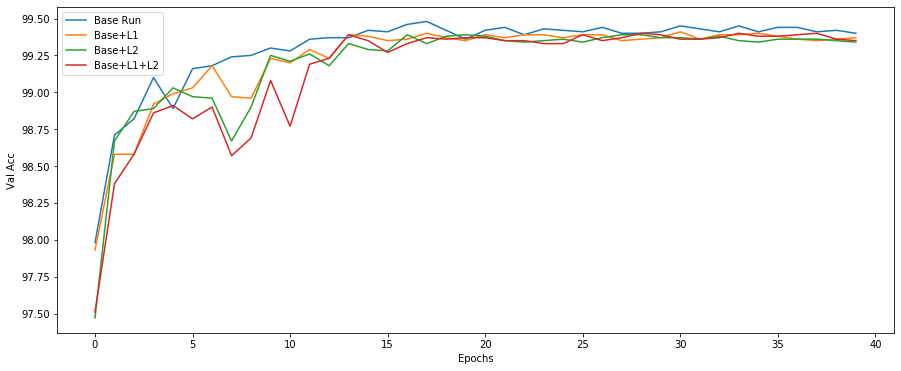

In [0]:
plot_graphs([base_metrics['Test Accuracy'], l1_metrics['Test Accuracy'], l2_metrics['Test Accuracy'], l1l2_metrics['Test Accuracy'] ],
            ['Base Run', 'Base+L1', 'Base+L2', 'Base+L1+L2'],
            xlabel="Epochs",
            ylabel="Val Acc")

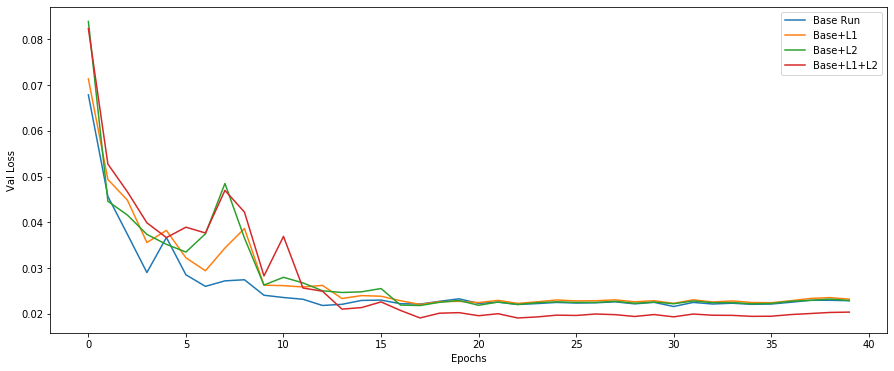

In [0]:
plot_graphs([base_metrics['Test Loss'], l1_metrics['Test Loss'], l2_metrics['Test Loss'], l1l2_metrics['Test Loss'] ],
            ['Base Run', 'Base+L1', 'Base+L2', 'Base+L1+L2'],
            xlabel="Epochs",
            ylabel="Val Loss")

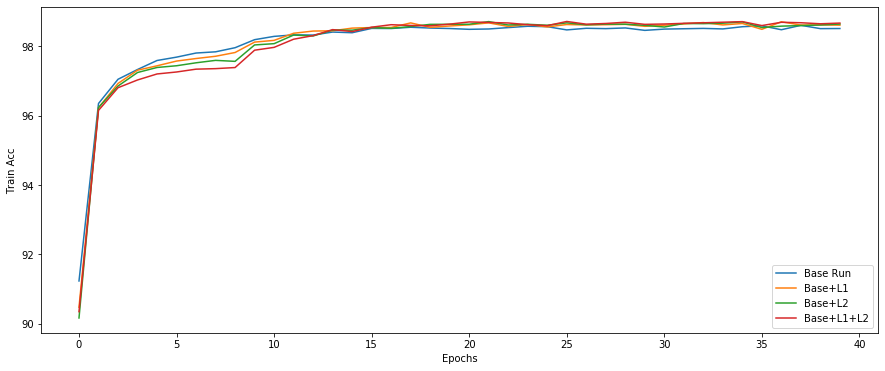

In [0]:
plot_graphs([base_metrics['Train Accuracy'], l1_metrics['Train Accuracy'], l2_metrics['Train Accuracy'], l1l2_metrics['Train Accuracy'] ],
            ['Base Run', 'Base+L1', 'Base+L2', 'Base+L1+L2'],
            xlabel="Epochs",
            ylabel="Train Acc")

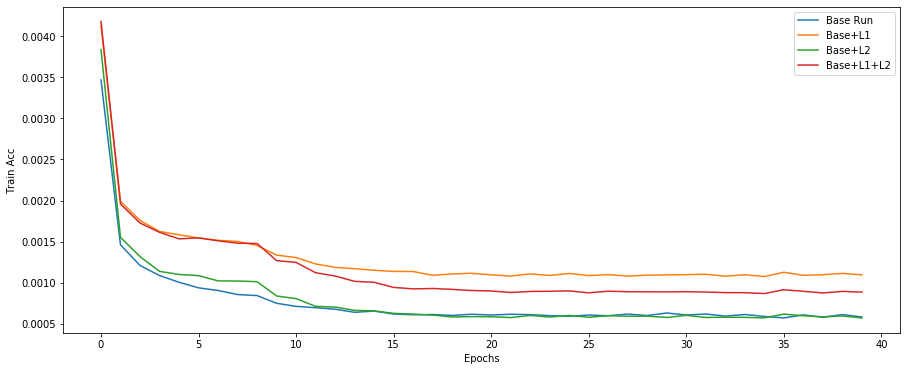

In [0]:
plot_graphs([base_metrics['Train Loss'], l1_metrics['Train Loss'], l2_metrics['Train Loss'], l1l2_metrics['Train Loss'] ],
            ['Base Run', 'Base+L1', 'Base+L2', 'Base+L1+L2'],
            xlabel="Epochs",
            ylabel="Train Acc")

#### Misclassified images

In [0]:
BASE_MODEL="/content/drive/My Drive/EVA4/baseline_models/model-3176d58add_baserun40.h5"
L2_MODEL="/content/drive/My Drive/EVA4/baseline_models/model-1a74d5814d_baseline_l2.h5"
L1_MODEL="/content/drive/My Drive/EVA4/baseline_models/model-240a4abf69_baseline_l1.h5"
L1L2_MODEL="/content/drive/My Drive/EVA4/baseline_models/model-20e4e3377f_baseline_l1l2.h5"
my_model = model_builder(MNISTDigitBuilder, 
                      weights_path=L1L2_MODEL,
                      local_device=device)

In [0]:
def plot_misclassified(args, model, device, test_loader,classes,epoch_number):
    model.eval()
    test_loss = 0
    correct = 0
    preds = np.array([])
    actuals = np.array([])
    error_images = []
    total_misclassified = 0
    total_rounds = 0
    with torch.no_grad():
        for data, target in test_loader:
            #print(len(data))
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()
            #torch.
            #np.append(preds, pred.squeeze().cpu())
            orig_labels = target.cpu().numpy()
            pred_labels = pred.squeeze().cpu().numpy()
            #print(orig_labels.shape, pred_labels.shape)
            mislabeled_index = np.where(orig_labels != pred_labels)[0]
            #print(orig_labels)
            #print(pred_labels)
            total_rounds+=1
            if (mislabeled_index.shape[0] > 0):
                #print(mislabeled_index)
                for iCount in range(len(mislabeled_index)):            
                    #print(transforms.Normalize()data[offset]((-0.1307,), (1/0.3081,)))
                    #plt.imshow(data[offset].cpu().numpy().squeeze(), cmap='gray_r')
                    offset = mislabeled_index[iCount]
                    error_images.append(data[offset].cpu().numpy().squeeze())
                    preds=np.append(preds, pred_labels[offset])
                    actuals = np.append(actuals, orig_labels[offset])
                    total_misclassified += 1
                #error_images.append(data[mislabeled_index].cpu().numpy())#,axis=1)
                #preds=np.append(preds, pred_labels[mislabeled_index])
                

        #example_images.append(wandb.Image(
        #        data[0], caption="Pred: {} Truth: {}".format(classes[pred[0].item()], classes[target[0]])))
    #print("Total images worked on:",total_rounds)
    test_loss /= len(test_loader.dataset)
    test_accuracy = (100. * correct) / len(test_loader.dataset)
    print((total_misclassified))
    print(preds.shape)
    #print('\nEpoch: {:.0f} Test set: Average loss: {:.4f}, Accuracy: {}/{} ({:.3f}%)\n'.format(
    #    epoch_number, test_loss, correct, len(test_loader.dataset),
    #    100. * correct / len(test_loader.dataset)))
    #test_acc.append(test_accuracy)
    #test_losses.append(test_loss)

    # figure = plt.figure()
    # num_of_images = total_misclassified
    # for index in range(1, num_of_images):
    #     plt.subplot(5, 13, index)
    #     plt.axis('off')
    #     plt.imshow(error_images[index], cmap='gray_r')
    #     #plt.label
    fig = plt.figure(figsize=(10,10))
    for idx in np.arange(25):
        ax = fig.add_subplot(5, 5, idx+1, xticks=[], yticks=[])
        plt.imshow(error_images[idx], cmap='gray_r')
        #ax.set_title("Pred="+str(np.int(preds[idx])))
        ax.set(ylabel="Pred="+str(np.int(preds[idx])), xlabel="Actual="+str(np.int(actuals[idx])))

    return test_accuracy, test_loss, None#error_images#, data(np.where(orig_labels != pred_labels))

In [0]:
kwargs_2 = {'num_workers': 4, 'pin_memory': True} if use_cuda else {}
train_loader_2 = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=True, download=True,
                    transform=train_transforms),
    batch_size=config.batch_size, shuffle=True, **kwargs_2)
test_loader_2 = torch.utils.data.DataLoader(
        datasets.MNIST('../data', train=False, transform=test_transforms),
        batch_size=config.batch_size, shuffle=True, **kwargs_2)

len(train_loader_2),len(test_loader_2)

(938, 157)

65
(65,)
99.35 0.020358985495567323


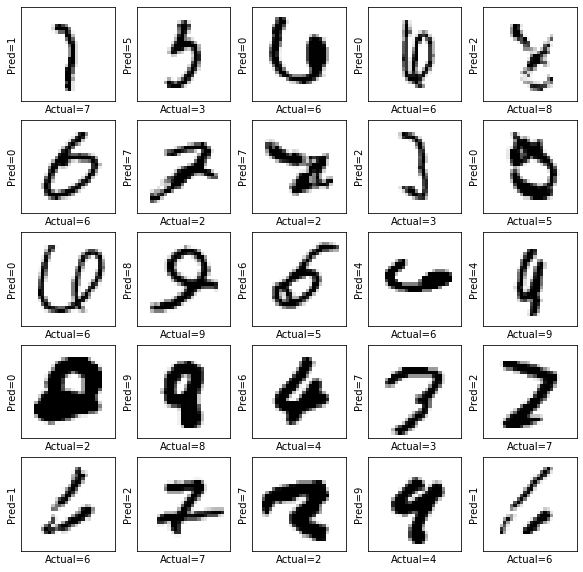

In [44]:
type(my_model)
classes = ('0', '1', '2', '3', '4', '5', '6', '7', '8', '9')
epoch_test_acc,epoch_test_loss,preds = test_preds(config, my_model, device, test_loader_2, classes,1)
print(epoch_test_acc,epoch_test_loss)
#print(preds)